In [1]:
# Basic imports
import numpy as np
import pandas as pd
# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from scipy.stats import boxcox

In [2]:
df = pd.read_csv("data\kc_house_data.csv")

In [3]:
# Dataframe Cleaning

# Duplicate id
df.drop(index=df.index[4846], axis=0, inplace=True)
# Dropping NAs
df = df.dropna(subset=["heat_source", "sewer_system"], axis=0)

In [4]:
# Dataframe Cleaning

# Dropping price outliers
p_mean = df['price'].mean()
p_std = df['price'].std()
p_max = p_mean + p_std
p_min = p_mean - p_std
df = df.loc[(df['price'] > p_min) & (df['price'] < p_max)]
df.info()

# Getting zipcode from address
df['zipcode'] = df['address'].str.extract(r'(\d{5})').astype(int)

# Changing the column type from obj to int and getting rid of the extra words
df['grade'] = df['grade'].str.split().str[0]
df['grade'] = df['grade'].astype(int)

# Use boolean indexing to get all the addresses that contain "Washington"
df = df[df['address'].str.contains("Washington")]

# Reset the index
df = df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27108 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             27108 non-null  int64  
 1   date           27108 non-null  object 
 2   price          27108 non-null  float64
 3   bedrooms       27108 non-null  int64  
 4   bathrooms      27108 non-null  float64
 5   sqft_living    27108 non-null  int64  
 6   sqft_lot       27108 non-null  int64  
 7   floors         27108 non-null  float64
 8   waterfront     27108 non-null  object 
 9   greenbelt      27108 non-null  object 
 10  nuisance       27108 non-null  object 
 11  view           27108 non-null  object 
 12  condition      27108 non-null  object 
 13  grade          27108 non-null  object 
 14  heat_source    27108 non-null  object 
 15  sewer_system   27108 non-null  object 
 16  sqft_above     27108 non-null  int64  
 17  sqft_basement  27108 non-null  int64  
 18  sqft_g

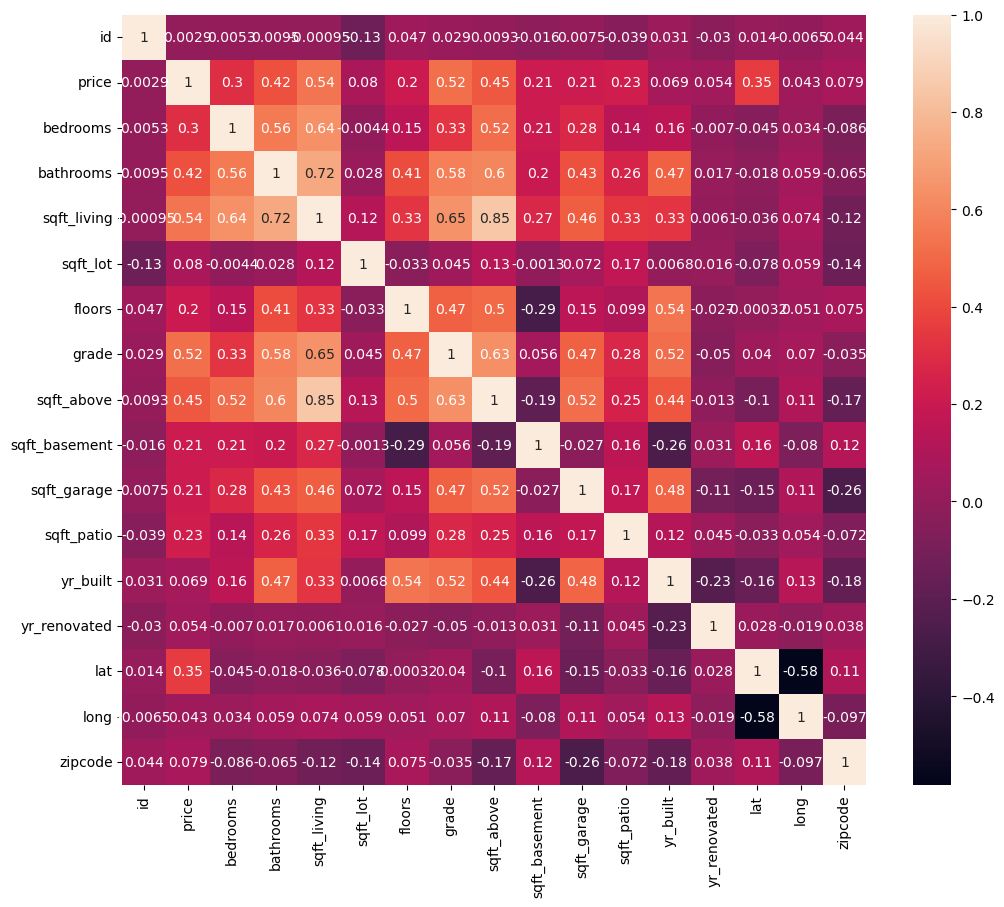

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [6]:
df.groupby('yr_built').mean()['price'].plot()

<AxesSubplot:xlabel='yr_built'>

<AxesSubplot:xlabel='bathrooms'>

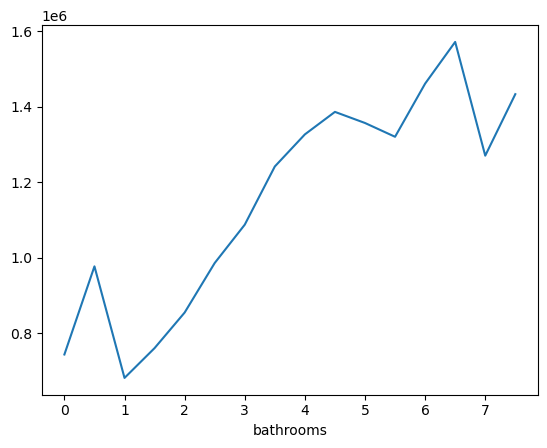

In [7]:
df.groupby('bathrooms').mean()['price'].plot()

In [8]:
import datetime
current_year = datetime.datetime.now().year
df['age'] = current_year - df['yr_built']

In [9]:
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)

In [10]:
view_mapping = {
    "NONE": 0,
    "FAIR": 1,
    "AVERAGE": 2,
    "GOOD": 3,
    "EXCELLENT": 4
}

df["view_num"] = df["view"].map(view_mapping)

In [11]:
df["has_basement"] = df["sqft_basement"].apply(lambda x: 1 if x > 0 else 0)

In [12]:
df["has_waterfront"] = df["waterfront"].apply(lambda x: 1 if x == "YES" else 0)

In [13]:
# Convert 'YES' to 1 and 'NO' to 0 in the 'nuisance' column
df['has_nuisance'] = df['nuisance'].apply(lambda x: 1 if x == 'YES' else 0)

In [14]:
condition_mapping = {
    "Poor": 0,
    "Fair": 1,
    "Average": 2,
    "Good": 3,
    "Very Good": 4
}

df["condition"] = df["condition"].map(condition_mapping)

In [15]:
cols_to_drop = df.select_dtypes(include=['object']).columns
X = df.drop(columns=cols_to_drop)
X = X.drop("price", axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                             columns=X_test.columns,
                             index=X_test.index)

In [16]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train_scaled, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train_scaled)

# Calculate the R^2 score on the training data
r2_score(y_train, train_preds)

0.5869541595500574

In [17]:
dict(zip(X_train.columns, model_sk.coef_))

{'id': -2050.847419810426,
 'bedrooms': -4538.755237007434,
 'bathrooms': 25015.51230886805,
 'sqft_living': 87944.66209498013,
 'sqft_lot': 13412.618086083445,
 'floors': -8238.83993313246,
 'condition': 39887.83781675184,
 'grade': 111588.51462335447,
 'sqft_above': 56705.883061404485,
 'sqft_basement': 1822.1234397200299,
 'sqft_garage': 9551.544087397499,
 'sqft_patio': 6976.779834329182,
 'yr_built': -26381.838845548365,
 'yr_renovated': 1502260.8274039687,
 'lat': 211887.97993986736,
 'long': 131392.44239617186,
 'zipcode': 41355.88735124011,
 'age': 26381.838845581737,
 'renovated': -1492928.0401688837,
 'view_num': 34740.140155240944,
 'has_basement': 2361.452169420862,
 'has_waterfront': 6624.089741099572,
 'has_nuisance': -11656.03405103899}

In [18]:
mean_absolute_error(y_train, train_preds)

183104.9177026548

In [19]:
mean_squared_error(y_train, train_preds)

63618047360.97709

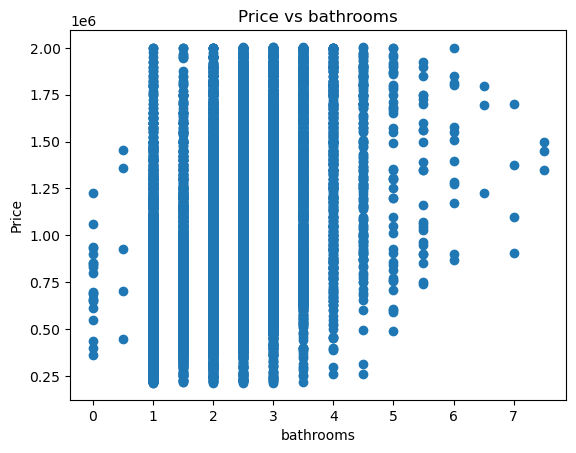

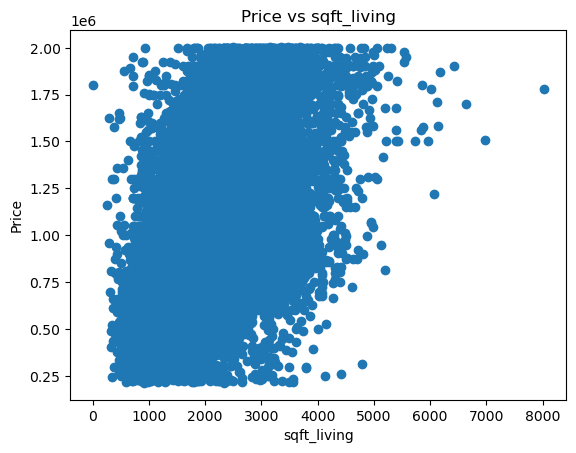

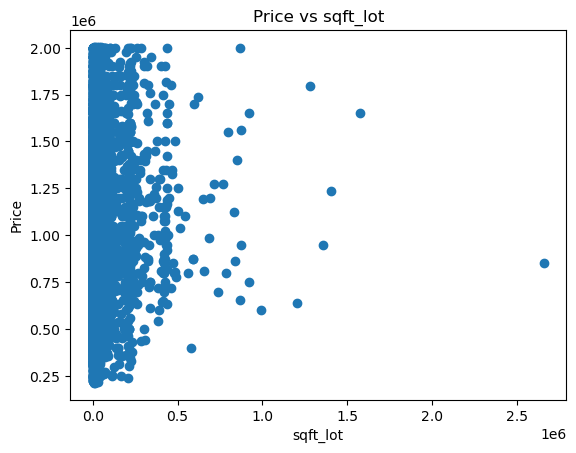

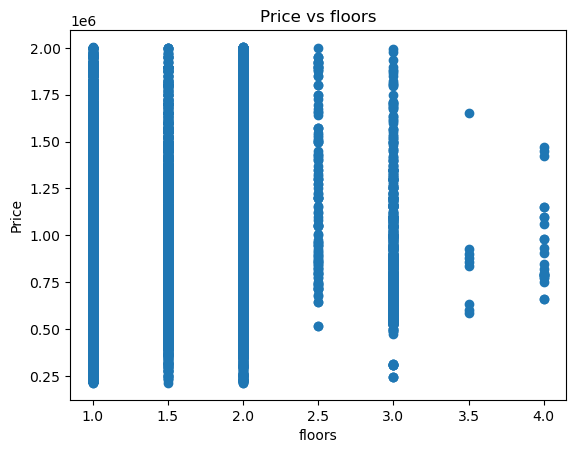

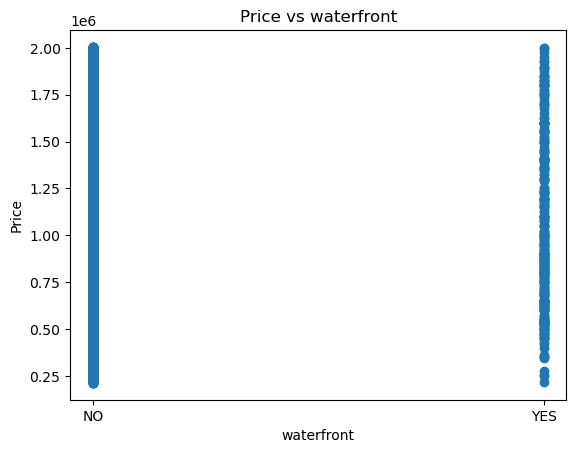

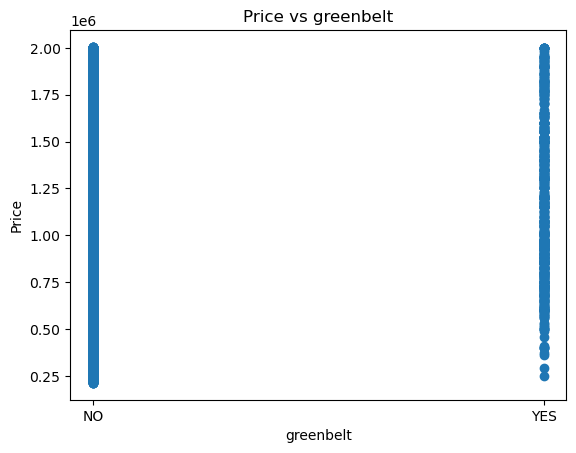

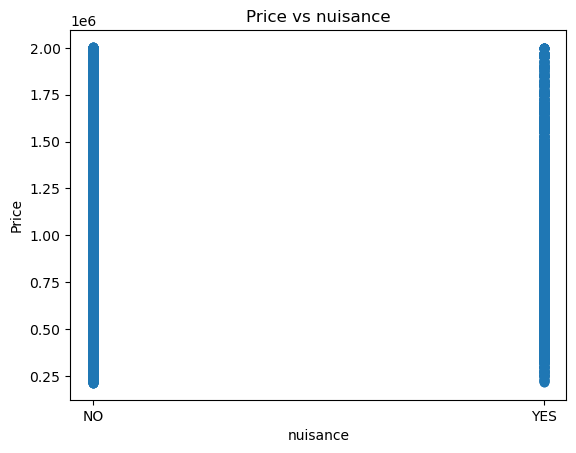

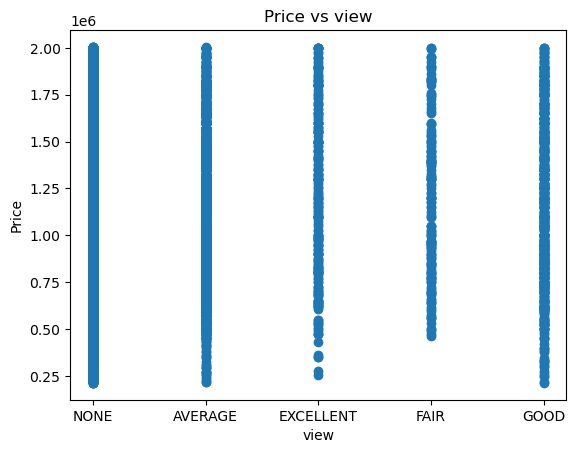

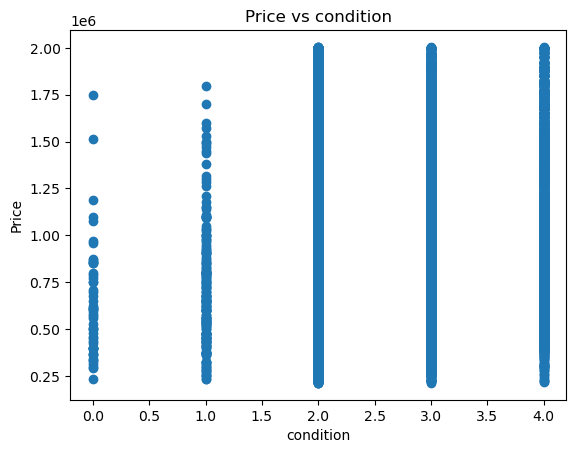

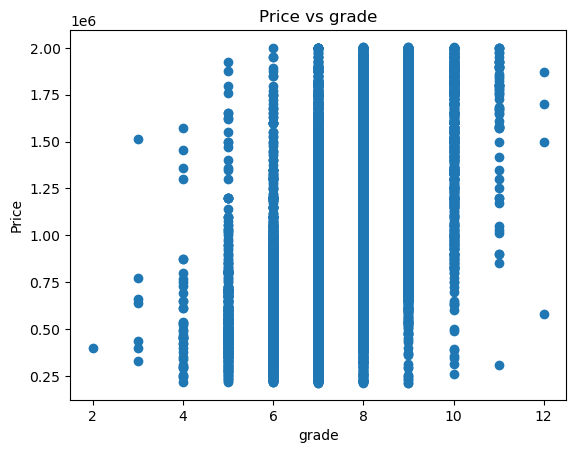

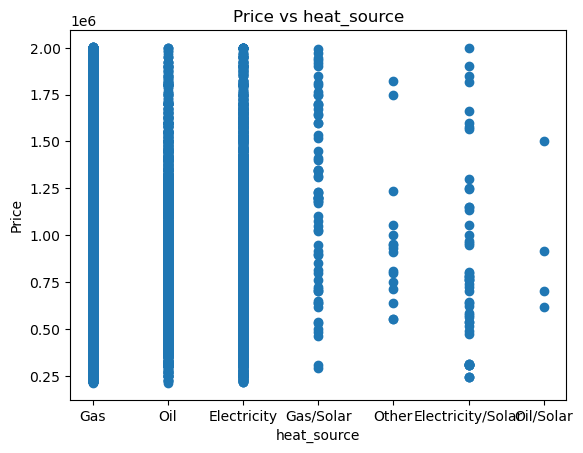

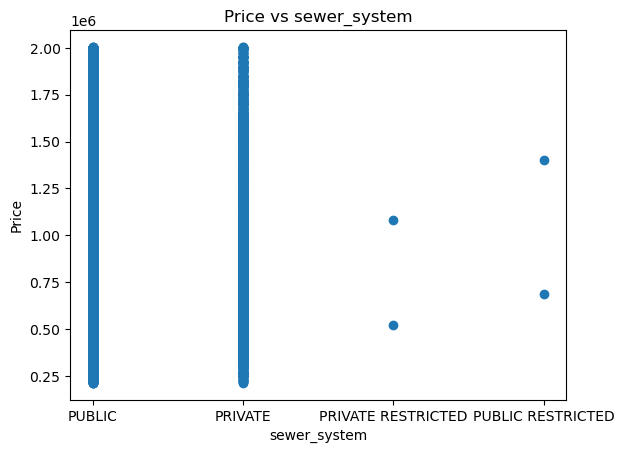

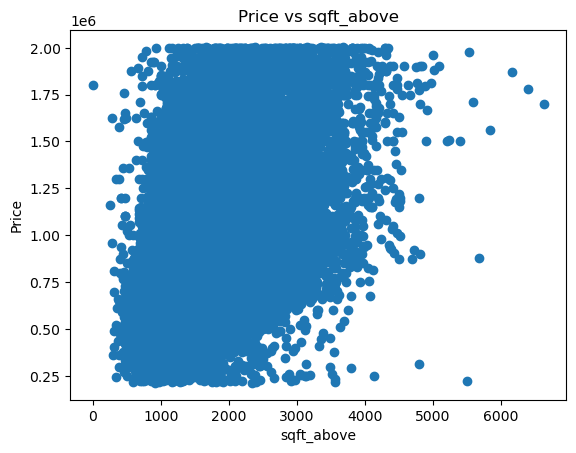

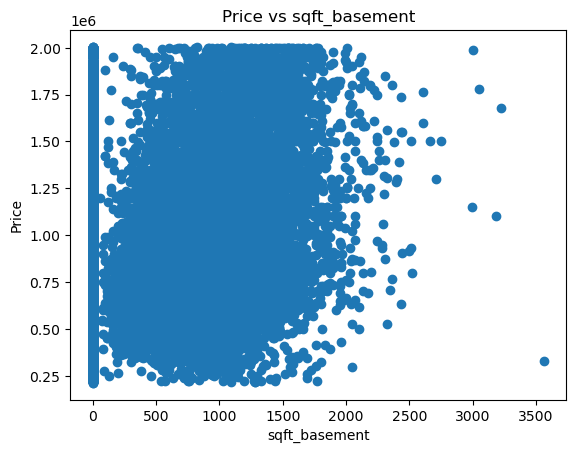

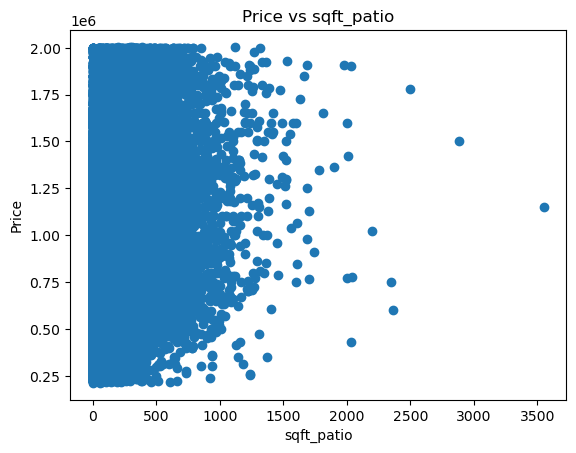

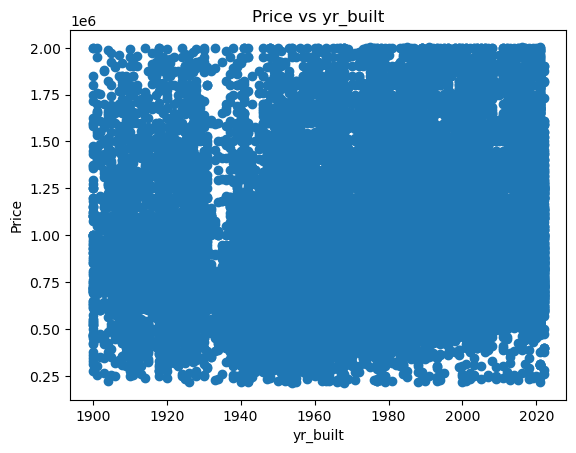

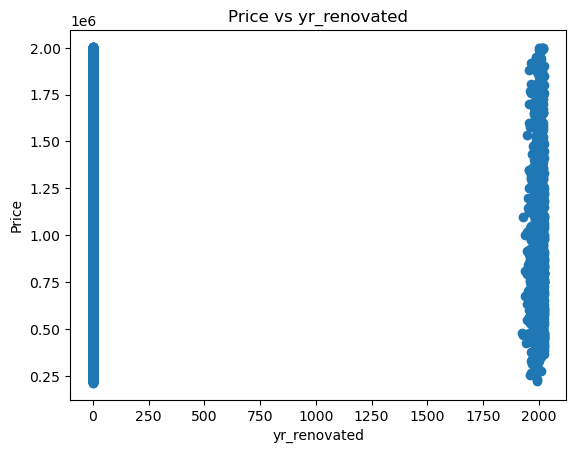

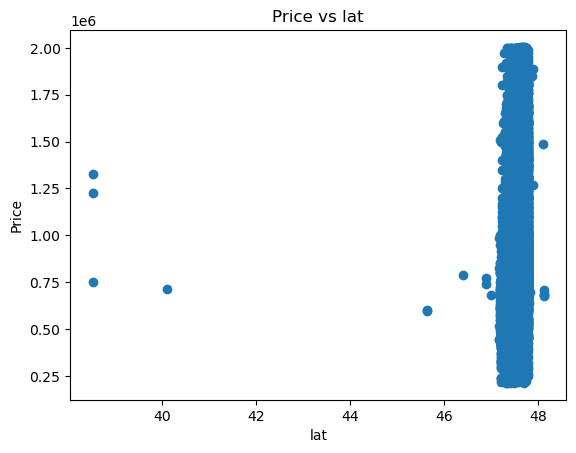

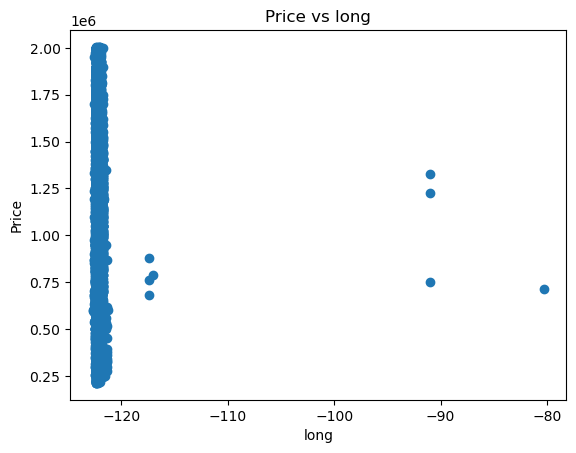

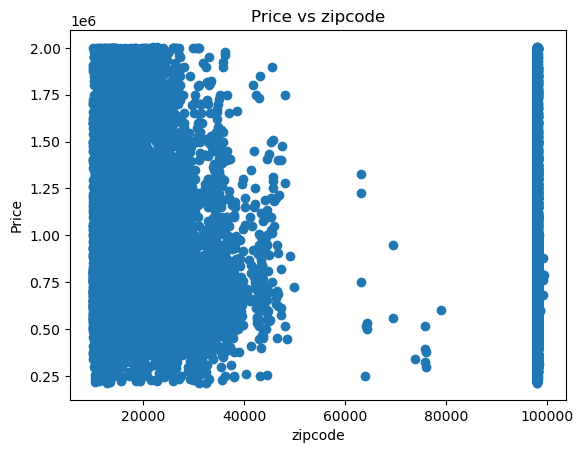

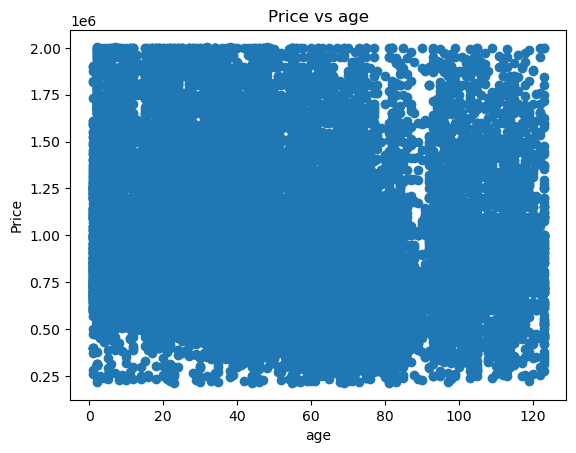

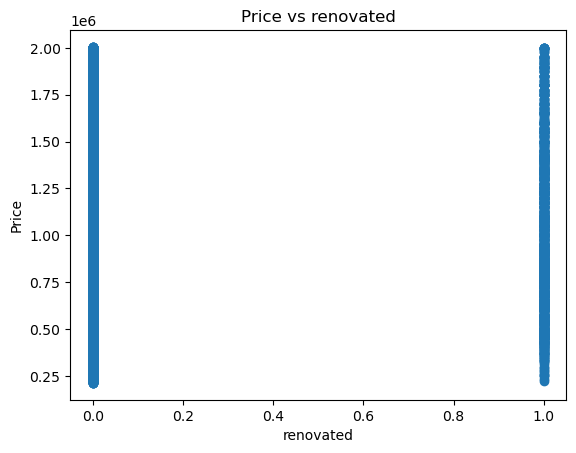

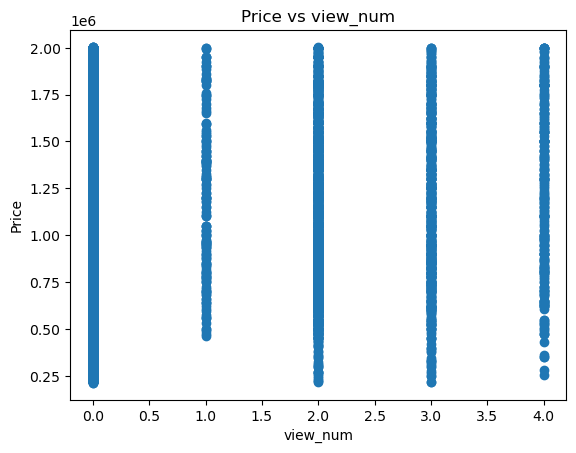

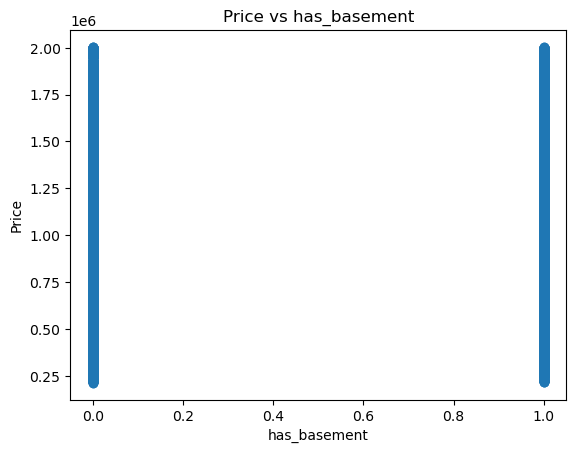

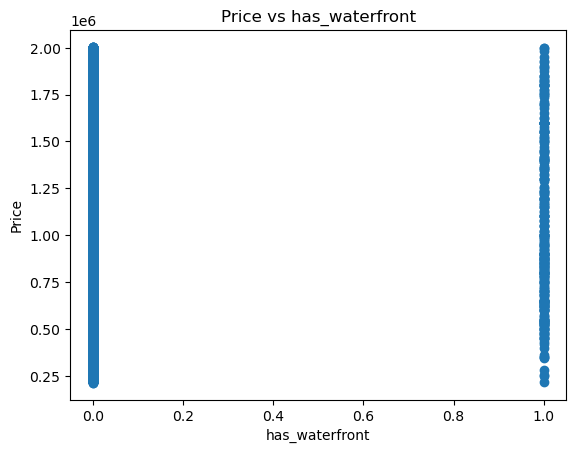

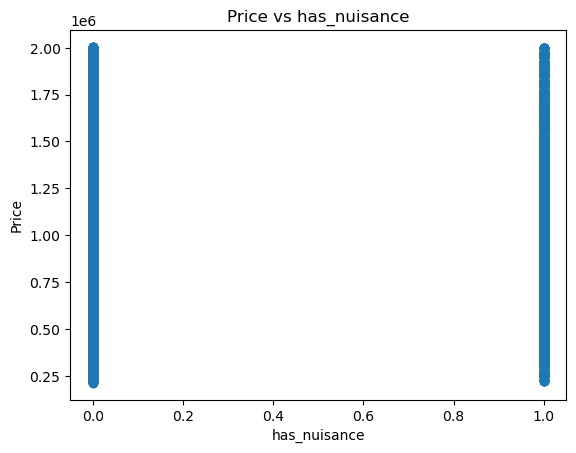

In [20]:
import matplotlib.pyplot as plt

# get list of column names
columns = list(df.columns)

# remove columns that are not independent variables
exclude = ['id', 'date', 'price', 'address']
columns = [col for col in columns if col not in exclude]

# loop over columns and create scatter plot with price
for col in columns:
    plt.scatter(df[col], df['price'])
    plt.title(f'Price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

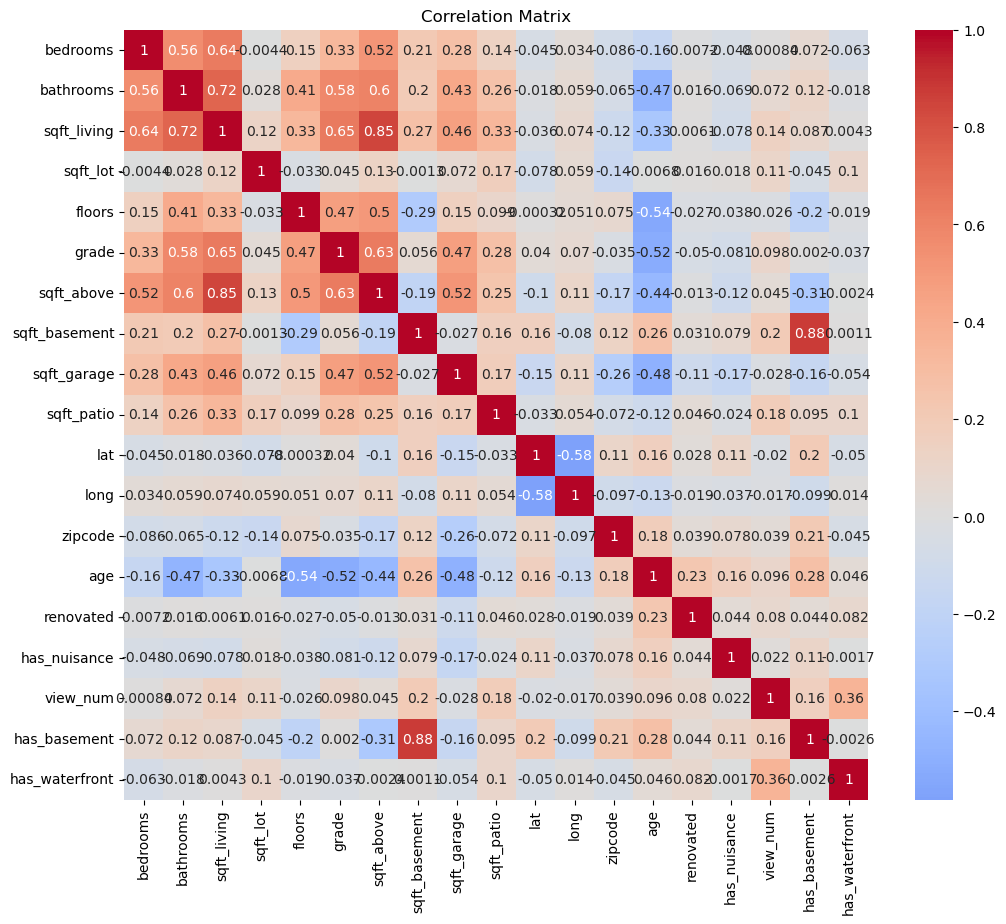

In [21]:
# get a subset of the dataframe with only the independent variables
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
           'grade', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
           'lat', 'long', 'zipcode', 'age', 'renovated', 'has_nuisance',
           'view_num', 'has_basement', 'has_waterfront']
X = df[columns]

# create correlation matrix
corr_matrix = X.corr()

# plot correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

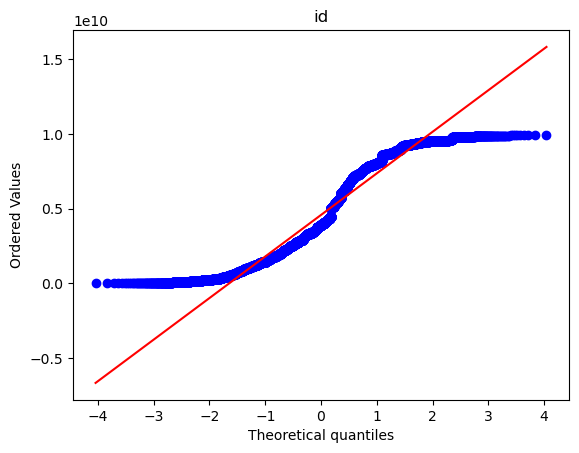

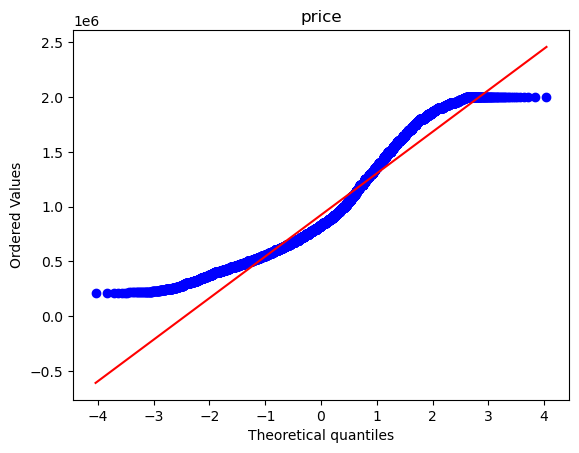

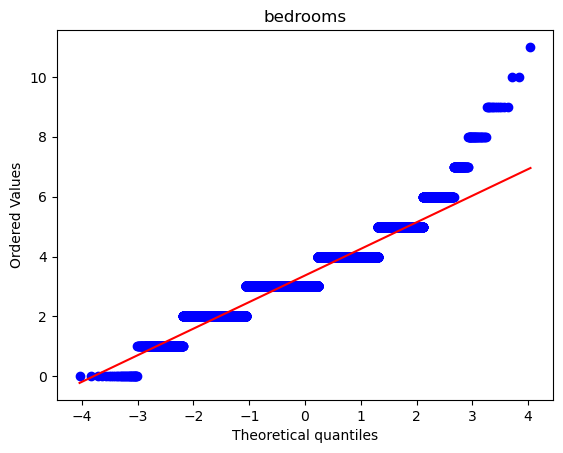

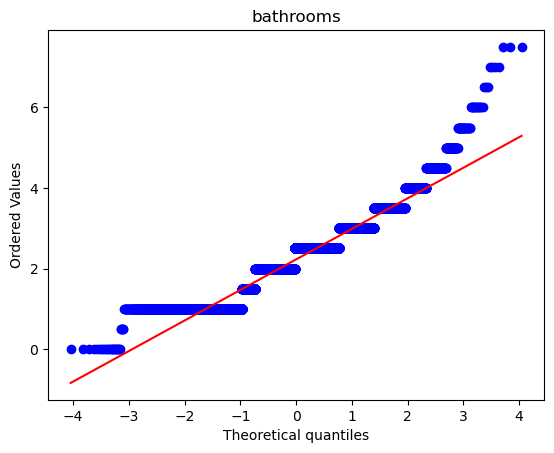

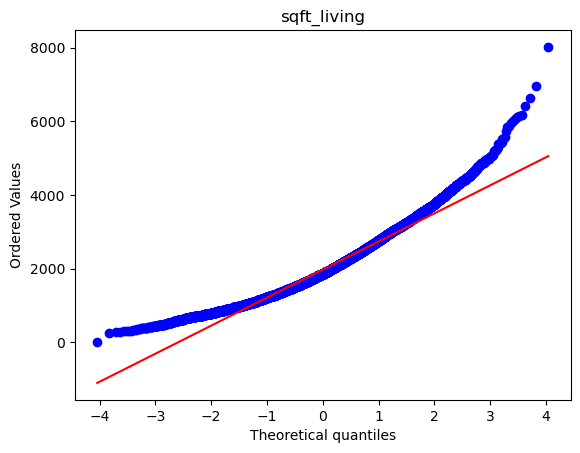

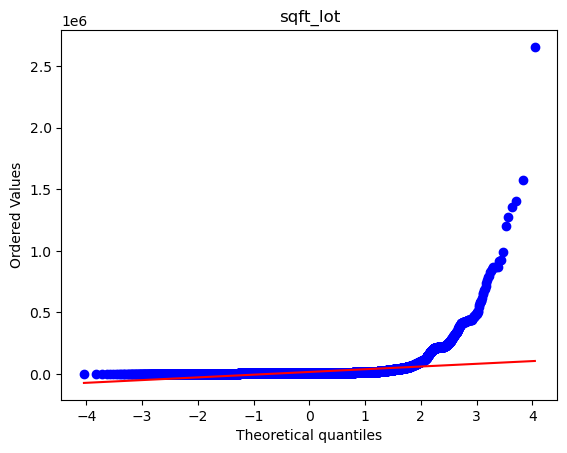

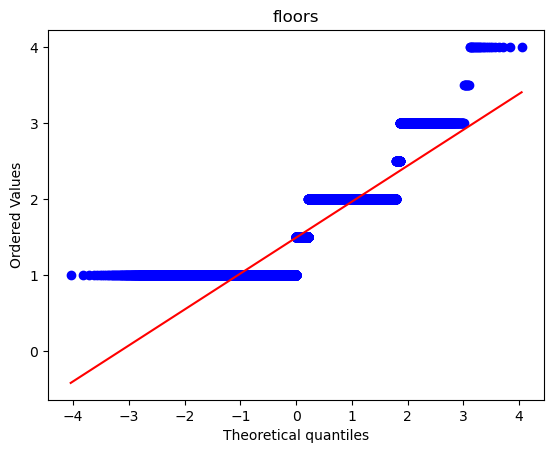

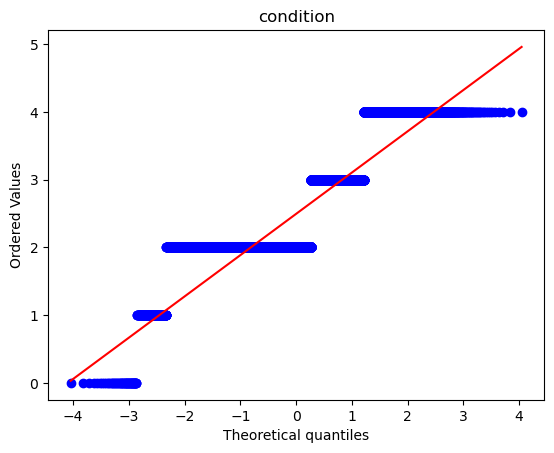

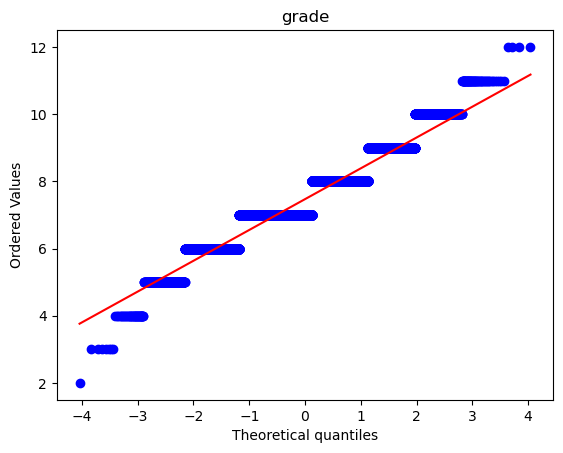

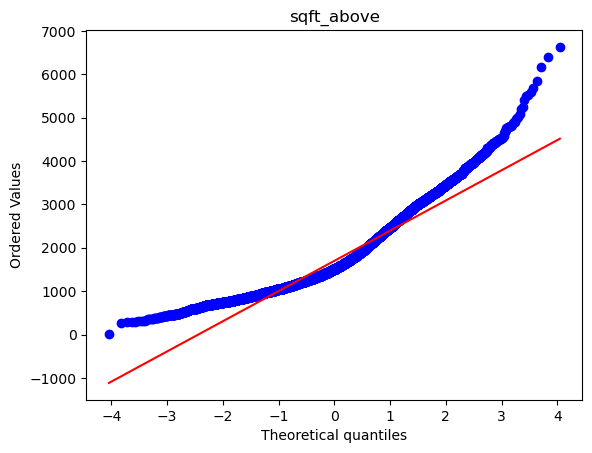

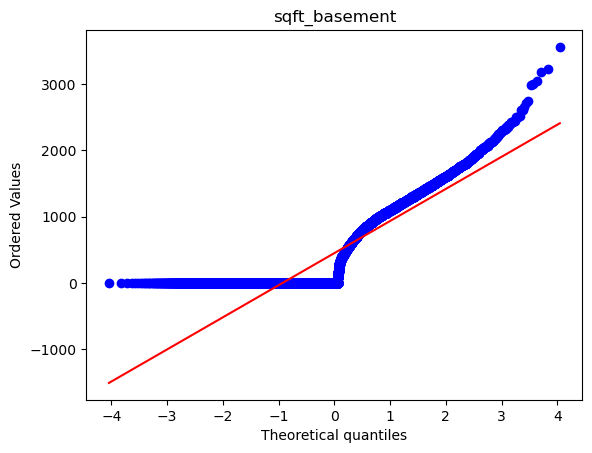

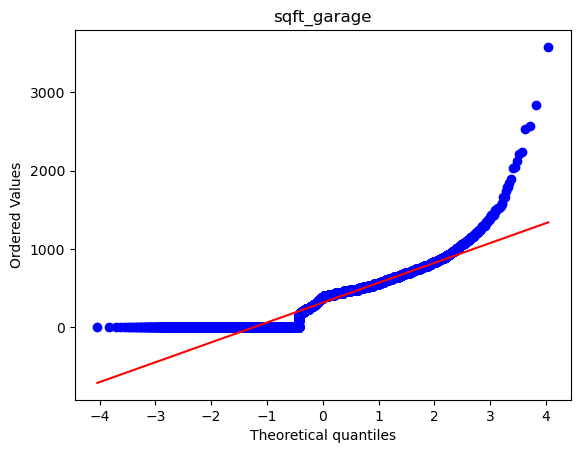

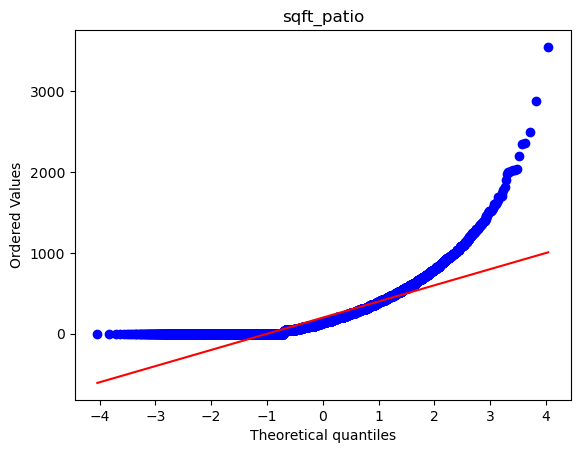

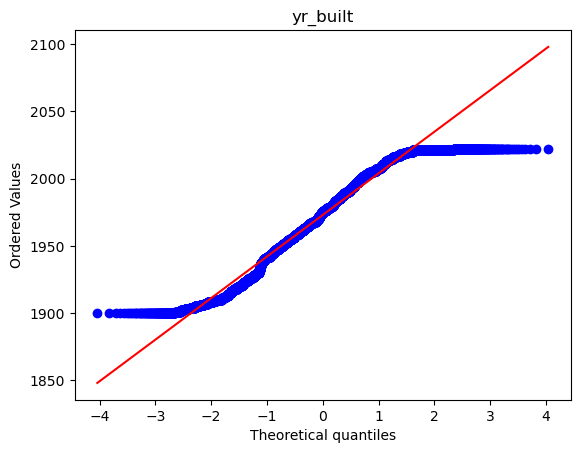

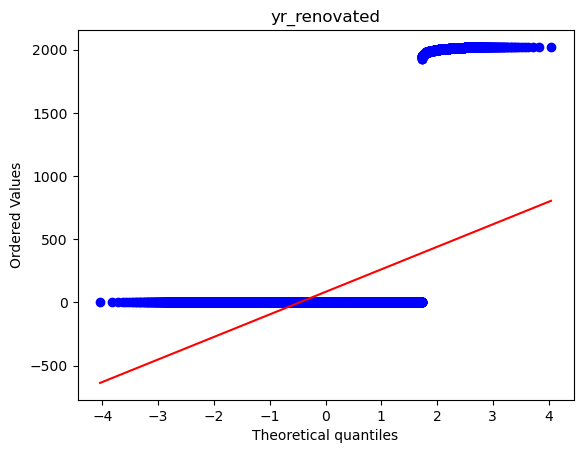

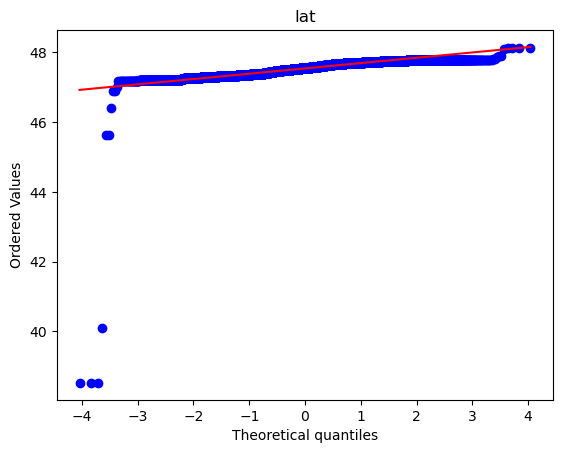

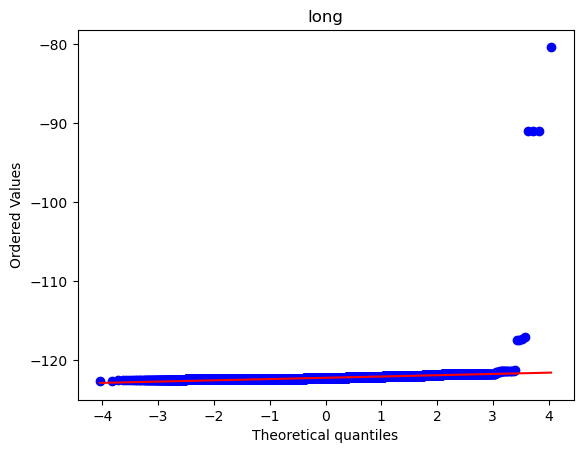

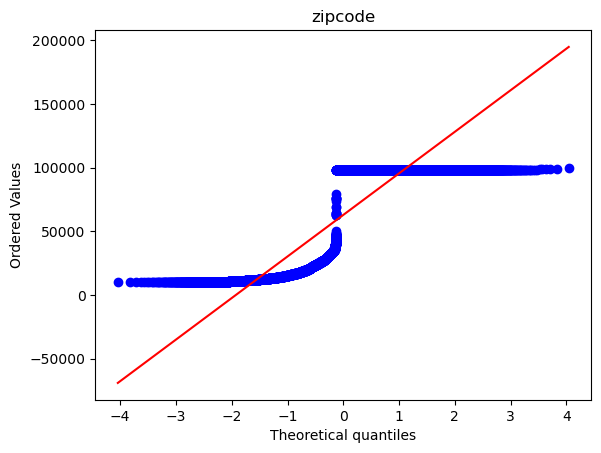

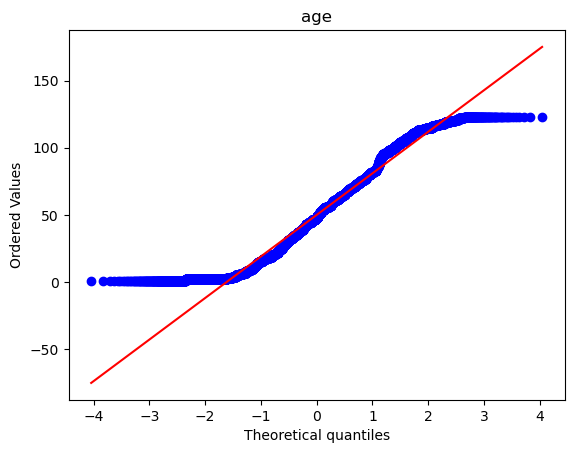

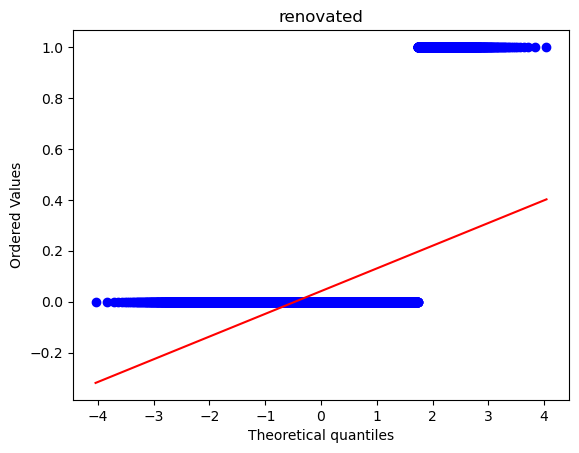

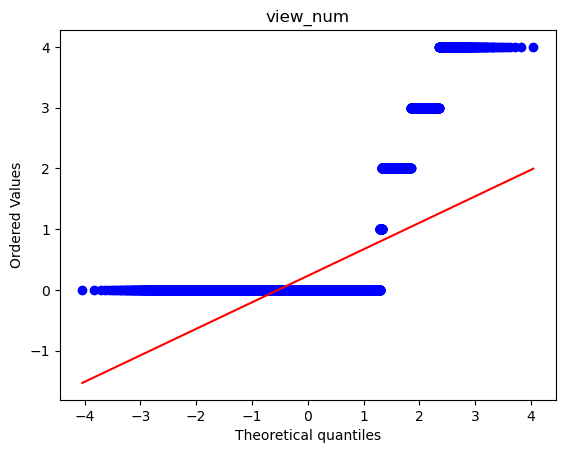

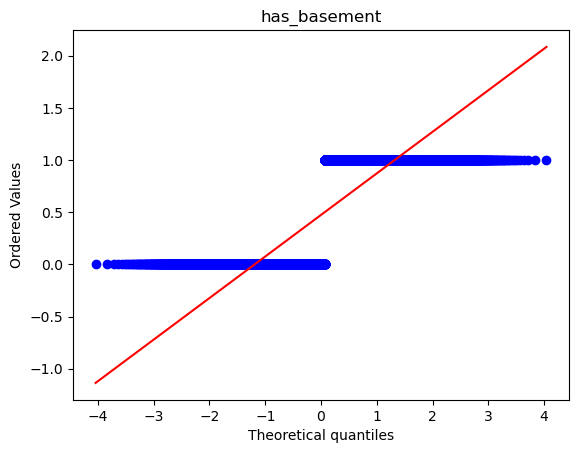

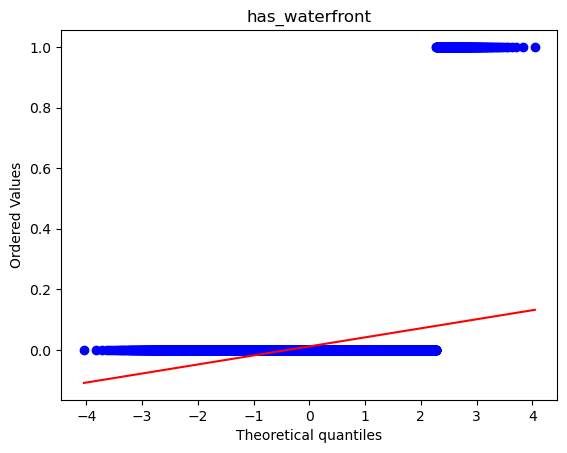

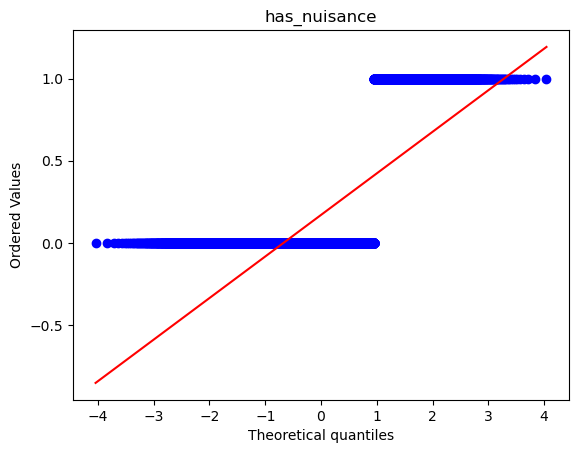

In [22]:
from scipy import stats

numerical_columns = df.select_dtypes(include=['int64', 'float64', 'int32']).columns

# create a normal probability plot for each numerical column
for column in numerical_columns:
    fig, ax = plt.subplots()
    stats.probplot(df[column], plot=ax)
    ax.set_title(column)
    plt.show()

In [23]:
def remove_outliers(df, cols):
    """
    Remove outliers from a DataFrame for specified columns using the interquartile range (IQR) method.

    Args:
        df (pandas.DataFrame): DataFrame to remove outliers from.
        cols (list): List of column names to remove outliers from.

    Returns:
        pandas.DataFrame: DataFrame with outliers removed for specified columns.
    """
    df_out = df.copy()
    for col in cols:
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
    return df_out

In [24]:
cols_to_filter = ['sqft_living', 'sqft_patio', 'sqft_garage', 'sqft_basement', 'sqft_lot']
filtered_df = remove_outliers(df, cols_to_filter)

print('Original shape:', df.shape)
print('Filtered shape:', filtered_df.shape)

Original shape: (26250, 32)
Filtered shape: (22464, 32)


In [25]:
filtered_df['total_sqft'] = filtered_df['sqft_living'] + filtered_df['sqft_lot'] + filtered_df['sqft_above'] + filtered_df['sqft_basement'] + filtered_df['sqft_garage'] + filtered_df['sqft_patio']

In [26]:
cols_to_drop = ['waterfront', 'greenbelt', 'nuisance', "view", 'date', 'heat_source', 'sewer_system', 'address', "id", 'age']
filtered_df = filtered_df.drop(columns=cols_to_drop)

In [27]:
df.corr()['price'].sort_values(ascending=False)

price             1.000000
sqft_living       0.541596
grade             0.521703
sqft_above        0.449356
bathrooms         0.420312
lat               0.354245
bedrooms          0.303915
sqft_patio        0.233008
sqft_garage       0.214707
sqft_basement     0.211353
floors            0.203968
view_num          0.180484
has_basement      0.143481
sqft_lot          0.080252
zipcode           0.079125
yr_built          0.069294
yr_renovated      0.053509
renovated         0.053318
long              0.042635
has_waterfront    0.031127
condition         0.031085
id                0.002896
has_nuisance     -0.012196
age              -0.069294
Name: price, dtype: float64

In [28]:
filtered_df.corr()['price'].sort_values(ascending=False)

price             1.000000
sqft_living       0.523458
grade             0.498357
sqft_above        0.410085
bathrooms         0.395388
lat               0.361568
bedrooms          0.295272
sqft_basement     0.225715
total_sqft        0.223441
sqft_patio        0.194846
floors            0.183799
view_num          0.183742
sqft_garage       0.167507
has_basement      0.164931
zipcode           0.116677
yr_renovated      0.062330
renovated         0.062154
yr_built          0.035643
condition         0.030785
long              0.029734
sqft_lot          0.017760
has_waterfront    0.014576
has_nuisance     -0.001997
Name: price, dtype: float64

In [29]:
# filtered_df["price_by_total_sqft"] = filtered_df['price']/filtered_df['total_sqft']

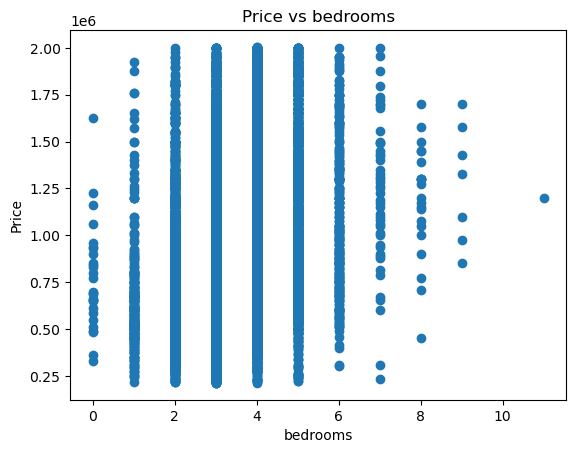

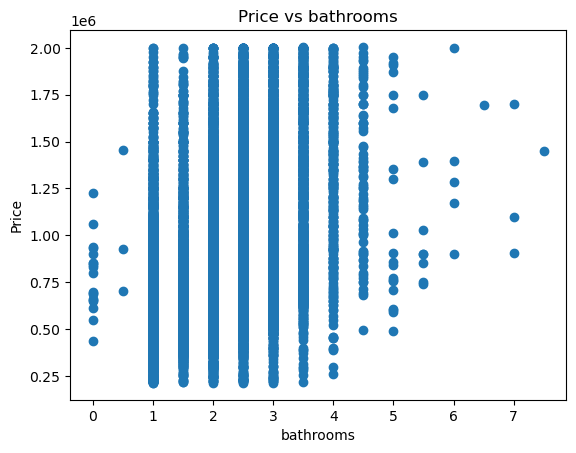

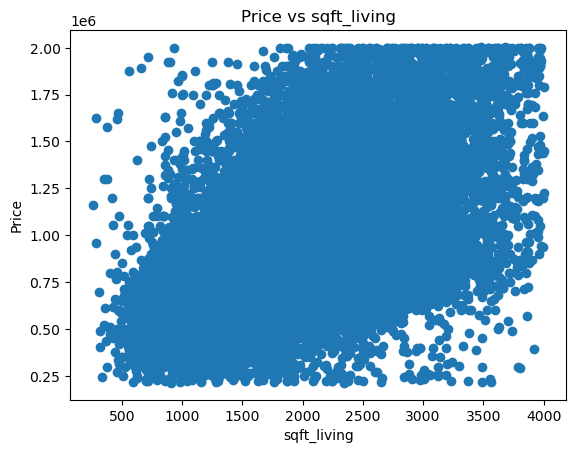

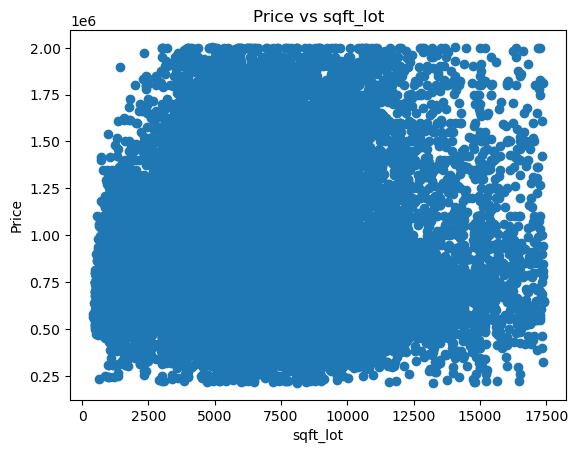

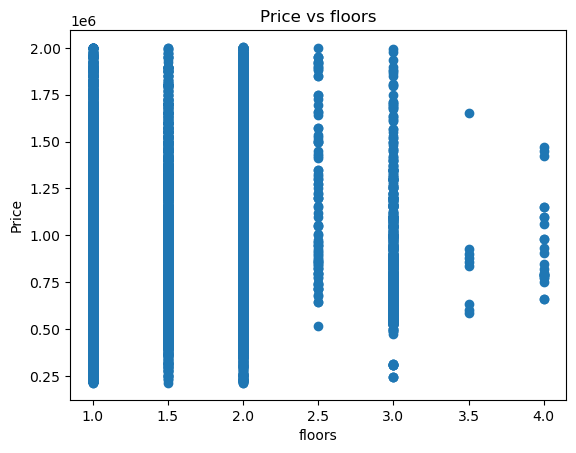

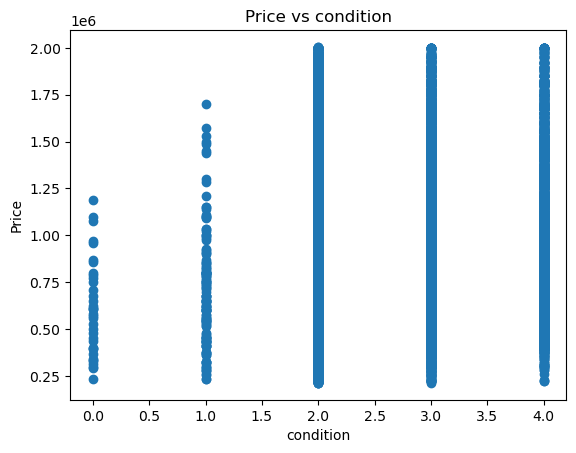

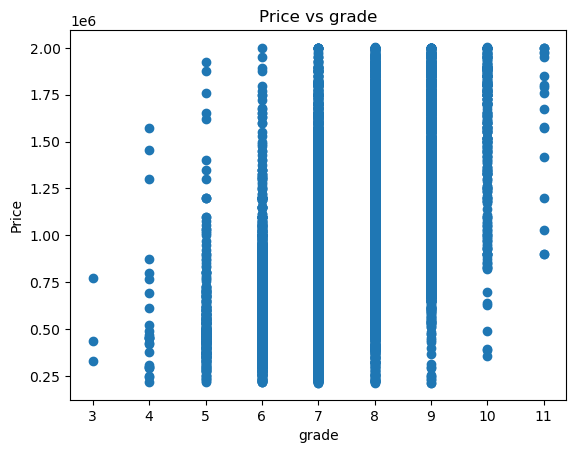

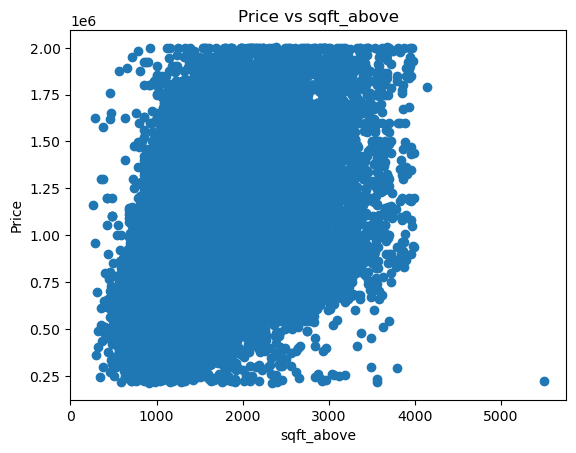

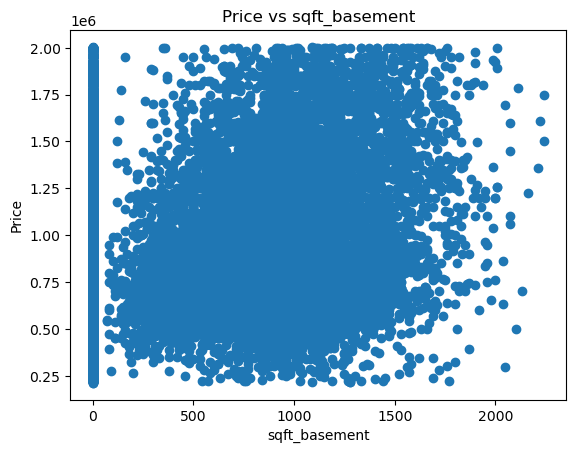

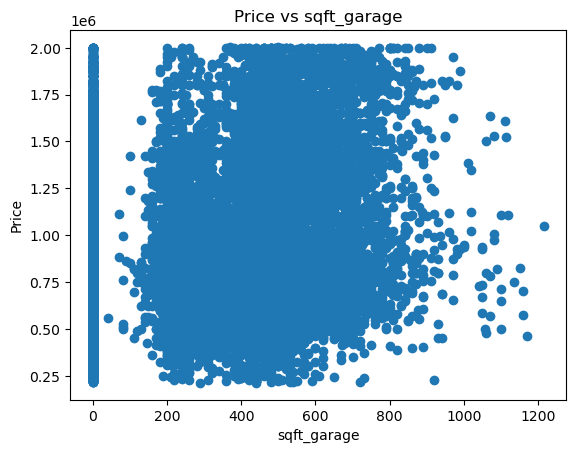

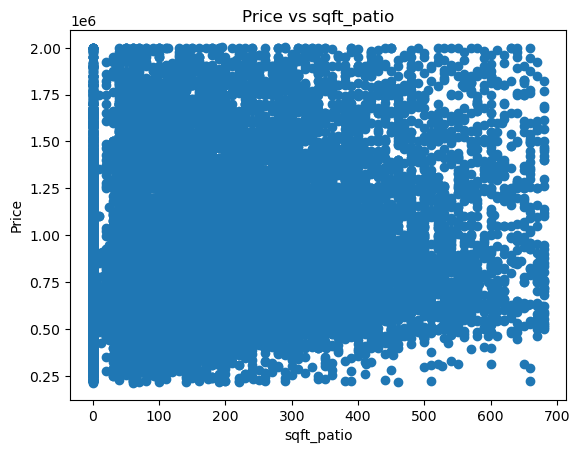

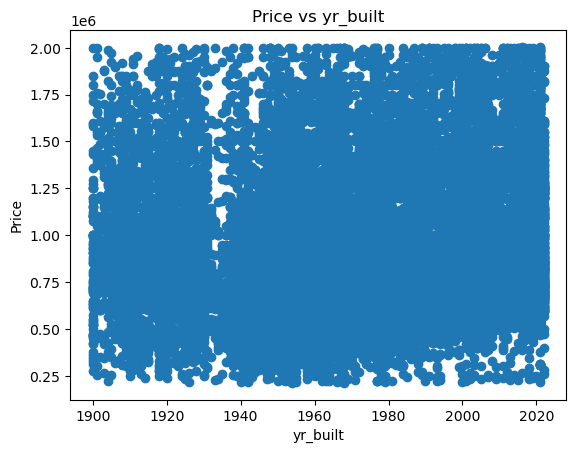

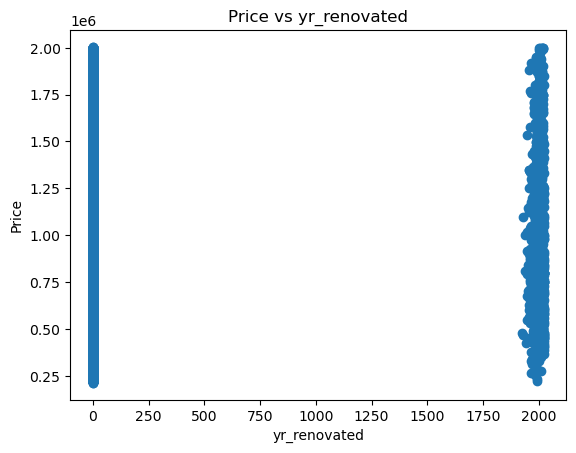

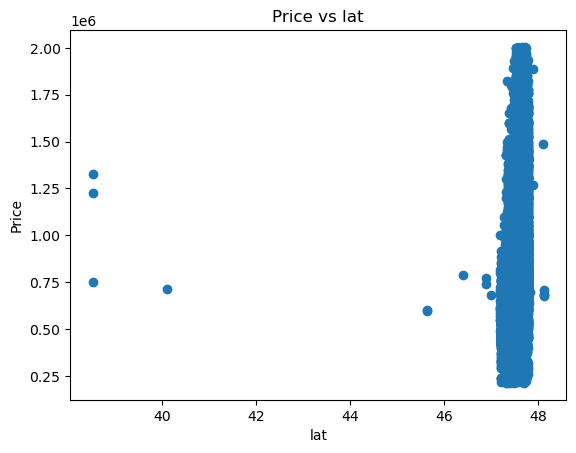

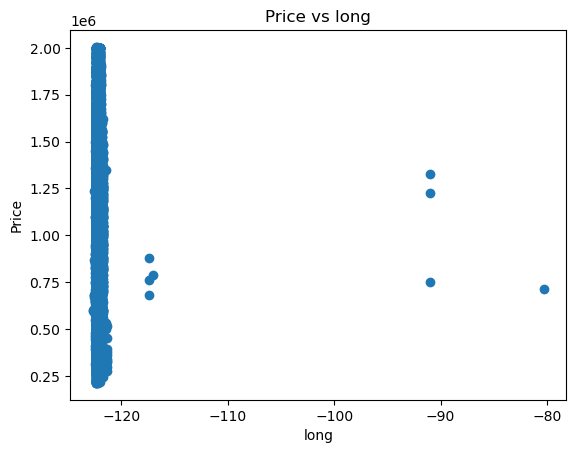

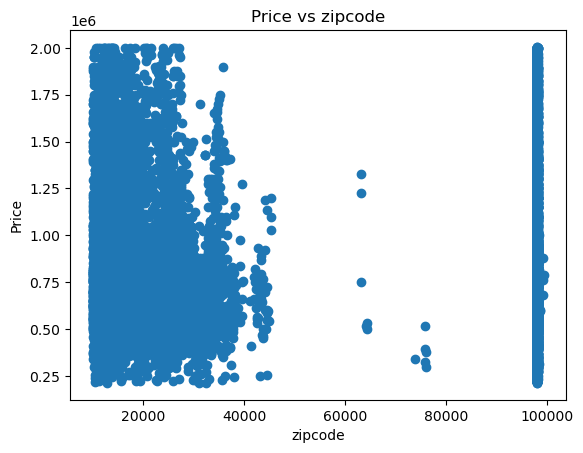

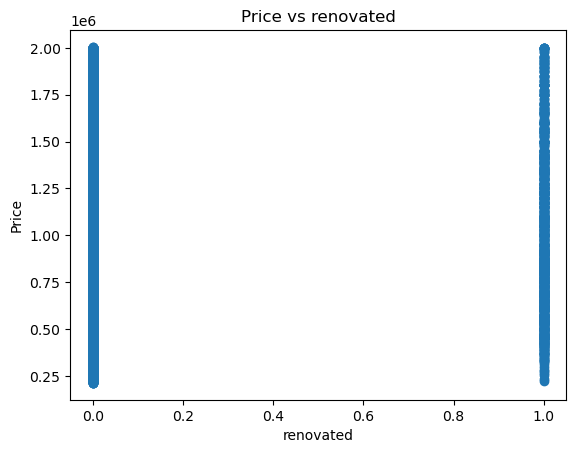

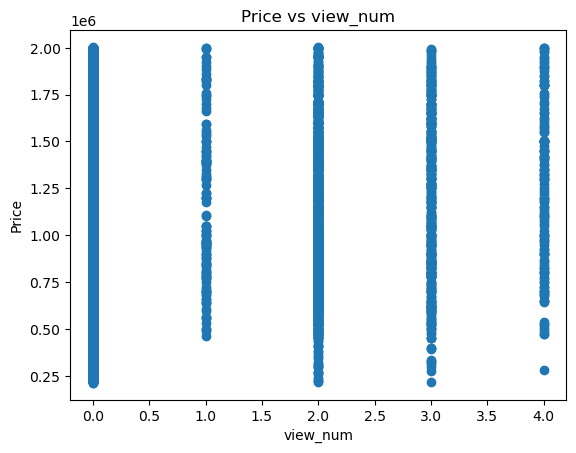

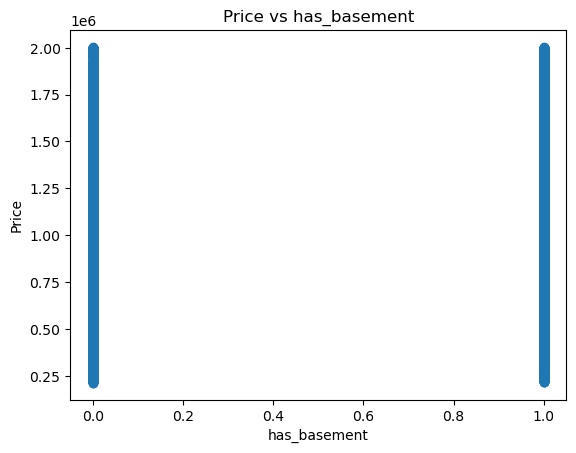

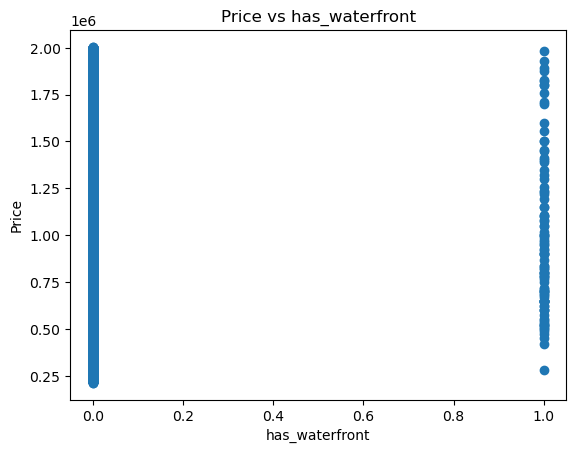

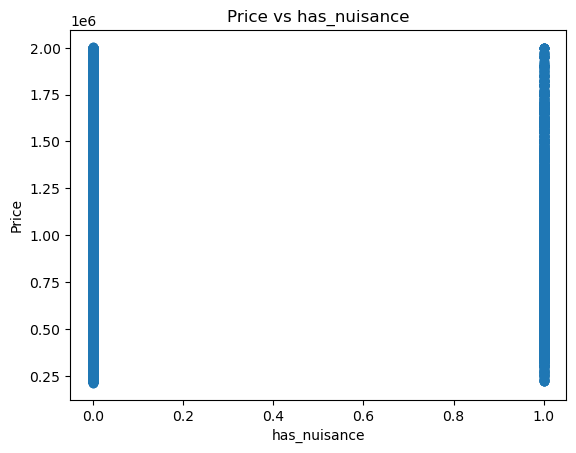

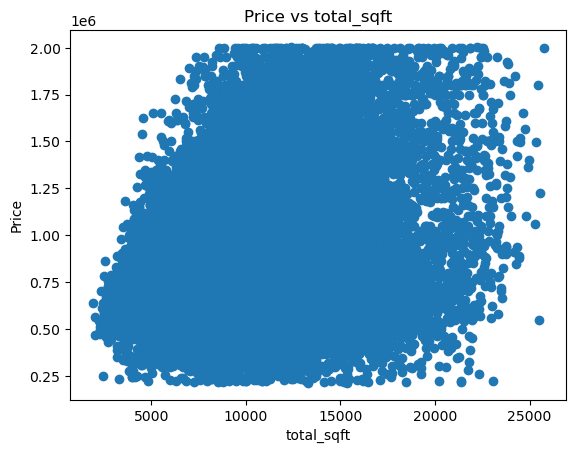

In [30]:
# get list of column names
columns = list(filtered_df.columns)

# remove columns that are not independent variables
exclude = ['id', 'date', 'price', 'address']
columns = [col for col in columns if col not in exclude]

# loop over columns and create scatter plot with price
for col in columns:
    plt.scatter(filtered_df[col], filtered_df['price'])
    plt.title(f'Price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

In [31]:
filtered_df.corr()["price"].sort_values(ascending=False)

price             1.000000
sqft_living       0.523458
grade             0.498357
sqft_above        0.410085
bathrooms         0.395388
lat               0.361568
bedrooms          0.295272
sqft_basement     0.225715
total_sqft        0.223441
sqft_patio        0.194846
floors            0.183799
view_num          0.183742
sqft_garage       0.167507
has_basement      0.164931
zipcode           0.116677
yr_renovated      0.062330
renovated         0.062154
yr_built          0.035643
condition         0.030785
long              0.029734
sqft_lot          0.017760
has_waterfront    0.014576
has_nuisance     -0.001997
Name: price, dtype: float64

In [32]:
# Split your data into features (X) and target (y)
# X = filtered_df.drop(columns=cols_to_drop)
X = filtered_df.drop("price", axis=1)
y = filtered_df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                             columns=X_test.columns,
                             index=X_test.index)

In [33]:
len(X_test)

7414

In [34]:
len(X_train)

15050

In [35]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train_scaled, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train_scaled)

# Calculate the R^2 score on the training data
r2_score(y_train, train_preds)

0.5958967080628135

In [36]:
dict(zip(X_train.columns, model_sk.coef_))

{'bedrooms': -5886.39816472051,
 'bathrooms': 22475.4075659218,
 'sqft_living': 90140.18823013862,
 'sqft_lot': -11754.387913422495,
 'floors': -11303.538584019818,
 'condition': 39240.845406804525,
 'grade': 106820.50011034602,
 'sqft_above': 49926.76971940449,
 'sqft_basement': 8549.02981951119,
 'sqft_garage': 8936.01404589953,
 'sqft_patio': 9056.704926541976,
 'yr_built': -62281.39827951471,
 'yr_renovated': 1165928.8186773243,
 'lat': 220006.79440503256,
 'long': 145385.14301797262,
 'zipcode': 45976.4076101612,
 'renovated': -1159112.0887470327,
 'view_num': 28753.81579364457,
 'has_basement': -7344.224097262237,
 'has_waterfront': 6602.549817207109,
 'has_nuisance': -7537.898606962108,
 'total_sqft': 16179.480192982886}

In [37]:
mean_absolute_error(y_train, train_preds)

174551.33540669794

In [38]:
np.sqrt(mean_squared_error(y_train, train_preds))

240578.63622195853

In [39]:
model_sk = LinearRegression()
model_sk.fit(X_train_scaled, y_train)
train_preds = model_sk.predict(X_test_scaled)

In [40]:
r2_score(y_test, train_preds)

0.605990758194852

In [41]:
mean_absolute_error(y_test, train_preds)

173613.4260021725

In [42]:
# filtered_df.corr()['price'].sort_values(ascending=False)

In [43]:
gis = pd.read_csv("data\kc_info.csv")
gis["type"].unique()

array(['Abandoned', 'Access_Point', 'Airport', 'Campground',
       'Commercial_Farm', 'Lodging', 'Gate_w/o_Building',
       'Gated_w/_Building', 'Cemetery', 'Government', 'Educational',
       'Cultural', 'Police', 'Fire', 'Public_Gathering', 'Seasonal_Home',
       'Utility'], dtype=object)

In [44]:
from scipy.spatial.distance import cdist

# define a list of relevant types
relevant_types = ['Airport', 
                  'Campground', 
                  'Commercial_Farm',
                  'Gate_w/o_Building',
                  'Gated_w/_Building',
                  'Lodging', 'Cemetery', 
                  'Government', 'Educational',
                  'Cultural', 'Police', 'Fire',
                  'Public_Gathering', 'Utility', 
                  'Seasonal_Home'
                 ]

# create an empty dataframe to hold the new columns
new_cols_df = pd.DataFrame()

# loop through each relevant type and apply the code
for type_name in relevant_types:
    type_df = gis[gis['type'] == type_name]
    coords_to_compare = type_df[['lat', 'lon']].values
    distances = cdist(filtered_df[['lat', 'long']].values, coords_to_compare, 'euclidean')
    closest_type_distance = distances.min(axis=1)
    filtered_df[f'min_dist_to_{type_name.lower()}'] = closest_type_distance
# concatenate the filtered_df with the new_cols_df
filtered_df = pd.concat([filtered_df, new_cols_df], axis=1)
filtered_df

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0       675000.0         4        1.0         1180      7140     1.0   
1       920000.0         5        2.5         2770      6703     1.0   
2       311000.0         6        2.0         2880      6156     1.0   
3       775000.0         3        3.0         2160      1400     2.0   
4       592500.0         2        2.0         1120       758     2.0   
...          ...       ...        ...          ...       ...     ...   
26245  1555000.0         5        2.0         1910      4000     1.5   
26246  1313000.0         3        2.0         2020      5800     2.0   
26247   800000.0         3        2.0         1620      3600     1.0   
26248   775000.0         3        2.5         2570      2889     2.0   
26249   500000.0         3        1.5         1200     11058     1.0   

       condition  grade  sqft_above  sqft_basement  ...  min_dist_to_lodging  \
0              3      7        1180              0  ...             0.021985   
1              2      7        1570           1570  ...             0.011772   
2              2      7        1580           1580  ...             0.021495   
3              2      9        1090           1070  ...             0.032737   
4              2      7        1120            550  ...             0.015641   
...          ...    ...         ...            ...  ...                  ...   
26245          3      8        1600           1130  ...             0.013054   
26246          2      7        2020              0  ...             0.011738   
26247          2      7         940            920  ...             0.018532   
26248          2      8        1830            740  ...             0.025812   
26249          2      7        1200              0  ...             0.029073   

       min_dist_to_cemetery  min_dist_to_government  min_dist_to_educational  \
0                  0.021290                0.004641                 0.006310   
1                  0.010485                0.011500                 0.007619   
2                  0.025218                0.016617                 0.005742   
3                  0.005743                0.006429                 0.005543   
4                  0.026618                0.011562                 0.022592   
...                     ...                     ...                      ...   
26245              0.016536                0.011485                 0.004325   
26246              0.032540                0.002446                 0.003452   
26247              0.025657                0.006452                 0.004329   
26248              0.033528                0.004081                 0.009943   
26249              0.037742                0.007779                 0.000647   

       min_dist_to_cultural  min_dist_to_police  min_dist_to_fire  \
0                  0.027789            0.107398          0.017121   
1                  0.024877            0.104042          0.027971   
2                  0.018978            0.063507          0.004546   
3                  0.020220            0.055818          0.010570   
4                  0.033429            0.140150          0.014659   
...                     ...                 ...               ...   
26245              0.014787            0.051273          0.023297   
26246              0.008291            0.058822          0.009924   
26247              0.008827            0.021899          0.011516   
26248              0.027256            0.114313          0.007720   
26249              0.037651            0.079431          0.008782   

       min_dist_to_public_gathering  min_dist_to_utility  \
0                          0.004093             0.002577   
1                          0.014596             0.007762   
2                          0.019718             0.003627   
3                          0.003289             0.003787   
4                          0.012483             0.003682   
...                             ...

In [45]:
filtered_df.corr()["price"].sort_values(ascending=False)

price                            1.000000
sqft_living                      0.523458
grade                            0.498357
sqft_above                       0.410085
bathrooms                        0.395388
lat                              0.361568
bedrooms                         0.295272
sqft_basement                    0.225715
total_sqft                       0.223441
sqft_patio                       0.194846
floors                           0.183799
view_num                         0.183742
sqft_garage                      0.167507
has_basement                     0.164931
zipcode                          0.116677
yr_renovated                     0.062330
renovated                        0.062154
yr_built                         0.035643
condition                        0.030785
long                             0.029734
min_dist_to_campground           0.027415
sqft_lot                         0.017760
min_dist_to_airport              0.017232
has_waterfront                   0

In [46]:
crime = pd.read_csv("data\kc_crime.csv")

In [47]:
# Create the list of towns and cities
towns_and_cities = ['Algona',
                    'Auburn',
                    'Beaux Arts Village', 
                    'Bellevue', 'Black Diamond', 
                    'Bothell', 'Burien', 'Carnation', 
                    'Clyde Hill', 'Covington', 
                    'Des Moines', 'Duvall', 
                    'Enumclaw', 
                    'Federal Way',
                    'Hunts Point', 
                    'Issaquah', 
                    'Kenmore', 
                    'Kent', 
                    'Kirkland',
                    'Lake Forest Park',
                    'Maple Valley',
                    'Medina',
                    'Mercer Island',
                    'Milton',
                    'Newcastle', 
                    'Normandy Park',
                    'North Bend', 
                    'Pacific',
                    'Redmond', 
                    'Renton', 
                    'Sammamish',
                    'SeaTac', 
                    'Seattle',
                    'Shoreline',
                    'Skykomish', 
                    'Snoqualmie',
                    'Tukwila', 
                    'Woodinville',
                    'Yarrow Point']

crime["city"] = crime["city"].str.title()

crime["city"] = crime["city"].apply(lambda x: next((town for town in towns_and_cities if town in x), None))

In [48]:
crime = crime.dropna()

In [49]:
crime_by_zip = crime.groupby('zip')["incident_type"].count().reset_index()

In [50]:
crime_by_zip = crime_by_zip.rename(columns={"incident_type": "crime_count"})

In [51]:
filtered_df['zipcode'] = filtered_df['zipcode'].astype(str)
merged_df = filtered_df.merge(crime_by_zip, left_on='zipcode', right_on='zip')

In [52]:
merged_df = merged_df.drop('zip', axis=1)
merged_df

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0       675000.0         4        1.0         1180      7140     1.0   
1       750000.0         3        2.0         1830      7969     1.0   
2       728000.0         4        2.0         2170      7520     1.0   
3       565000.0         4        2.0         1400     10364     1.5   
4       645000.0         3        2.0         1520      8250     1.0   
...          ...       ...        ...          ...       ...     ...   
13279  1602000.0         5        3.0         3090      7186     2.0   
13280  1599950.0         4        3.5         3170      7205     2.0   
13281  1585000.0         4        3.5         3170      7443     2.0   
13282   640000.0         4        3.5         2422      6557     2.0   
13283  1004136.0         4        2.5         2940      5100     2.0   

       condition  grade  sqft_above  sqft_basement  ...  min_dist_to_cemetery  \
0              3      7        1180              0  ...              0.021290   
1              2      7         930            930  ...              0.013324   
2              2      7        1240           1240  ...              0.019234   
3              3      6        1400              0  ...              0.031566   
4              2      8        1190            590  ...              0.022151   
...          ...    ...         ...            ...  ...                   ...   
13279          2      8        3090              0  ...              0.036083   
13280          2      8        3170              0  ...              0.036083   
13281          2      8        3170              0  ...              0.036083   
13282          2      8        2422              0  ...              0.108753   
13283          2      8        2940              0  ...              0.069663   

       min_dist_to_government  min_dist_to_educational  min_dist_to_cultural  \
0                    0.004641                 0.006310              0.027789   
1                    0.014662                 0.008786              0.015392   
2                    0.003213                 0.006998              0.029288   
3                    0.016545                 0.010127              0.004900   
4                    0.004121                 0.004173              0.029119   
...                       ...                      ...                   ...   
13279                0.019507                 0.005783              0.038669   
13280                0.019507                 0.005783              0.038669   
13281                0.019507                 0.005783              0.038669   
13282                0.041230                 0.029428              0.030302   
13283                0.009874                 0.005492              0.051584   

       min_dist_to_police  min_dist_to_fire min_dist_to_public_gathering  \
0                0.107398          0.017121                     0.004093   
1                0.084181          0.009434                     0.006018   
2                0.107335          0.019222                     0.002630   
3                0.095306          0.016859                     0.011131   
4                0.109520          0.016764                     0.005776   
...                   ...               ...                          ...   
13279            0.020899          0.019435                     0.011176   
13280            0.020899          0.019435                     0.011176   
13281            0.020899          0.019435                     0.011176   
13282            0.053328          0.035931                     0.029243   
13283            0.060235          0.005427                     0.006127   

       min_dist_to_utility  min_dist_to_seasonal_home  crime_count  
0                 0.002577                   0.325465           19  
1                 0.004733                   0.342316           19  
2                 0.003371                   0.323700           19  
3                 0.008

In [53]:
# merged_df['price_by_crime'] = merged_df['price'] / merged_df['crime_count']

In [54]:
# merged_df.drop('crime_count', axis=1, inplace=True)

In [55]:
# correlation = merged_df.corr()["price"]
# columns_to_drop = correlation[abs(correlation) < 0.20].index
# merged_df = merged_df.drop(columns_to_drop, axis=1)

In [56]:
merged_df.corr()["price"].sort_values(ascending=False)

price                            1.000000
sqft_living                      0.565888
grade                            0.502173
sqft_above                       0.448868
lat                              0.430010
bathrooms                        0.408885
bedrooms                         0.324878
sqft_basement                    0.264604
total_sqft                       0.260859
sqft_patio                       0.211803
view_num                         0.194729
min_dist_to_police               0.191894
sqft_garage                      0.184565
has_basement                     0.177959
min_dist_to_campground           0.161493
floors                           0.156363
min_dist_to_airport              0.151566
min_dist_to_cultural             0.139746
min_dist_to_cemetery             0.136414
long                             0.119774
min_dist_to_public_gathering     0.117794
min_dist_to_utility              0.083250
min_dist_to_government           0.082135
condition                        0

In [57]:
X = merged_df.drop("price", axis=1)
y = merged_df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                             columns=X_test.columns,
                             index=X_test.index)

In [58]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train)
test_preds = model_sk.predict(X_test)

# Calculate the R^2 score on the training data
print('Training R^2 score:', r2_score(y_train, train_preds))
print('Test R^2 score:', r2_score(y_test, test_preds))

Training R^2 score: 0.6747559466967633
Test R^2 score: 0.6990732768028671


In [59]:
dict(zip(X_train.columns, model_sk.coef_))

{'bedrooms': -8429.389362708393,
 'bathrooms': 26850.962186893117,
 'sqft_living': 68.60990199209624,
 'sqft_lot': -45.660603134419254,
 'floors': -28807.573407495085,
 'condition': 59375.50746357091,
 'grade': 81130.08458464402,
 'sqft_above': 81.55082519282328,
 'sqft_basement': -13.528071907033148,
 'sqft_garage': -54.39631172387449,
 'sqft_patio': 14.061833164850864,
 'yr_built': -1215.9486593284141,
 'yr_renovated': 2897.5078627126272,
 'lat': 863100.07548706,
 'long': -4105312.640360584,
 'zipcode': -318.42583688737255,
 'renovated': -5738749.276353547,
 'view_num': 35107.29938296694,
 'has_basement': -3816.1212267126525,
 'has_waterfront': 41911.783056401655,
 'has_nuisance': -33326.091774146305,
 'total_sqft': 50.63711934692839,
 'min_dist_to_airport': -1229992.3184227035,
 'min_dist_to_campground': -132371.90959205708,
 'min_dist_to_commercial_farm': -1374164.0951920575,
 'min_dist_to_gate_w/o_building': -2347742.3934436752,
 'min_dist_to_gated_w/_building': 2260426.791462782,

In [60]:
# Log-transform the target variable
y_log = np.log(y)

# Split the log-transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.33, random_state=42)

# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train)
test_preds = model_sk.predict(X_test)

# Convert the predicted log values back to their original scale
#train_preds = np.exp(train_preds)
#test_preds = np.exp(test_preds)

# Convert the true log values back to their original scale
#y_train = np.exp(y_train)
#y_test = np.exp(y_test)

# Calculate the R^2 score on the training data and test data
print('Training R^2 score:', r2_score(y_train, train_preds))
print('Test R^2 score:', r2_score(y_test, test_preds))

Training R^2 score: 0.681145130782846
Test R^2 score: 0.7132235475963016


In [61]:
len(train_preds)

8900

In [62]:
# merged_df = merged_df.drop(["sqft_garage", 
#                             "total_sqft", 
#                             "age",
#                             "has_nuisance",
#                             "condition", 
#                             "yr_renovated",
#                             "renovated", 
#                             "yr_built",
#                             "long",
#                             "has_waterfront"], axis=1)

In [63]:
merged_df.corr()["price"].sort_values(ascending=False)

price                            1.000000
sqft_living                      0.565888
grade                            0.502173
sqft_above                       0.448868
lat                              0.430010
bathrooms                        0.408885
bedrooms                         0.324878
sqft_basement                    0.264604
total_sqft                       0.260859
sqft_patio                       0.211803
view_num                         0.194729
min_dist_to_police               0.191894
sqft_garage                      0.184565
has_basement                     0.177959
min_dist_to_campground           0.161493
floors                           0.156363
min_dist_to_airport              0.151566
min_dist_to_cultural             0.139746
min_dist_to_cemetery             0.136414
long                             0.119774
min_dist_to_public_gathering     0.117794
min_dist_to_utility              0.083250
min_dist_to_government           0.082135
condition                        0

In [64]:
X = merged_df.drop("price", axis=1)
y = merged_df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [65]:
# Log-transform the target variable
y_log = np.log(y)

# Split the log-transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.33, random_state=42)

# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train)
test_preds = model_sk.predict(X_test)

# Convert the predicted log values back to their original scale
train_preds = np.exp(train_preds)
test_preds = np.exp(test_preds)

# Convert the true log values back to their original scale
y_train = np.exp(y_train)
y_test = np.exp(y_test)

# Calculate the R^2 score on the training data and test data
print('Training R^2 score:', r2_score(y_train, train_preds))
print('Test R^2 score:', r2_score(y_test, test_preds))

Training R^2 score: 0.6711827520034712
Test R^2 score: 0.6957765366121345


In [66]:
# Mean absolute error on training data
print("Mean absolute error on training data: ", mean_absolute_error(y_train, train_preds))

# Root mean squared error on training data
print("Root mean squared error on training data: ", np.sqrt(mean_squared_error(y_train, train_preds)))

Mean absolute error on training data:  156117.9709686841
Root mean squared error on training data:  224743.26927149054


In [67]:
# Mean absolute error on test data
print("Mean absolute error on test data: ", mean_absolute_error(y_test, test_preds))

# Root mean squared error on test data
print("Root mean squared error on test data: ", np.sqrt(mean_squared_error(y_test, test_preds)))

Mean absolute error on test data:  152282.73689672354
Root mean squared error on test data:  215247.31730023547


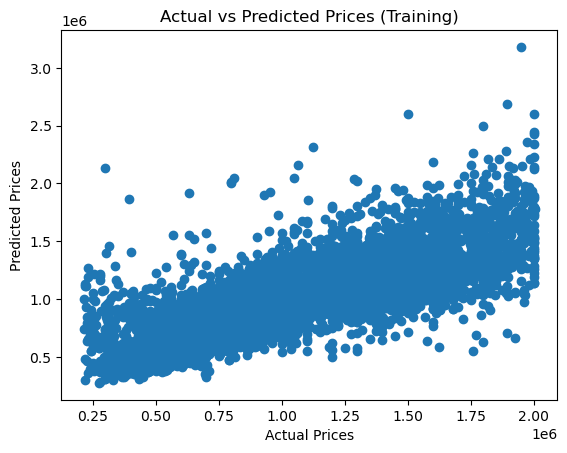

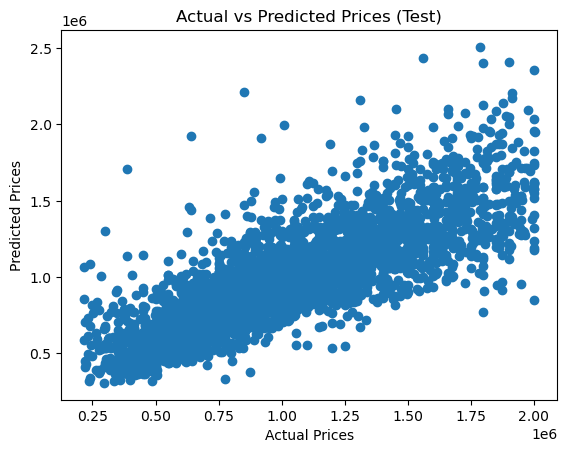

In [68]:
# Create scatter plot of actual vs predicted values for training data
plt.scatter(y_train, train_preds)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Training)')
plt.show()

# Create scatter plot of actual vs predicted values for test data
plt.scatter(y_test, test_preds)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Test)')
plt.show()

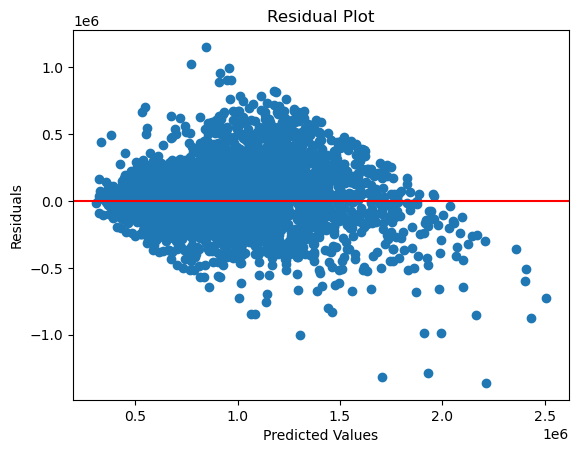

In [69]:
residuals = y_test - test_preds

plt.scatter(test_preds, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [70]:
from scipy.stats import shapiro

# Test for normality of the residuals using the Shapiro-Wilk test
stat, p = shapiro(residuals)
alpha = 0.05

if p > alpha:
    print('Residuals are likely Gaussian (fail to reject H0)')
else:
    print('Residuals are not Gaussian (reject H0)')

Residuals are not Gaussian (reject H0)


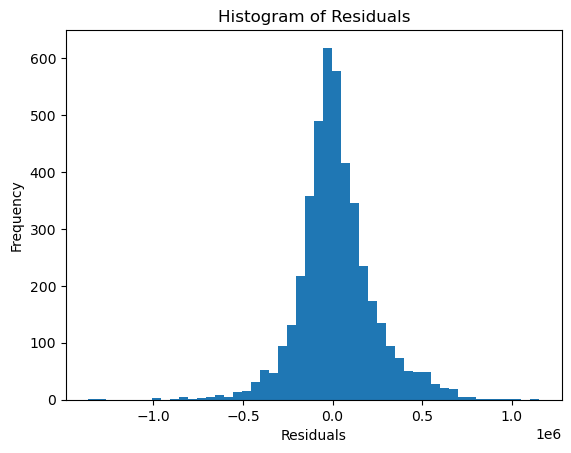

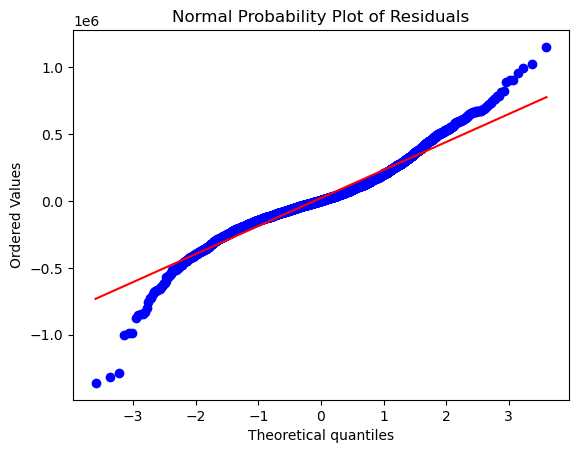

In [71]:
test_residuals = y_test - test_preds

# Create a histogram of the residuals
plt.hist(test_residuals, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Create a normal probability plot of the residuals

stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Normal Probability Plot of Residuals')
plt.show()

C:\Users\srini\AppData\Local\Temp\ipykernel_27936\238633526.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged_df.hist(ax = ax);


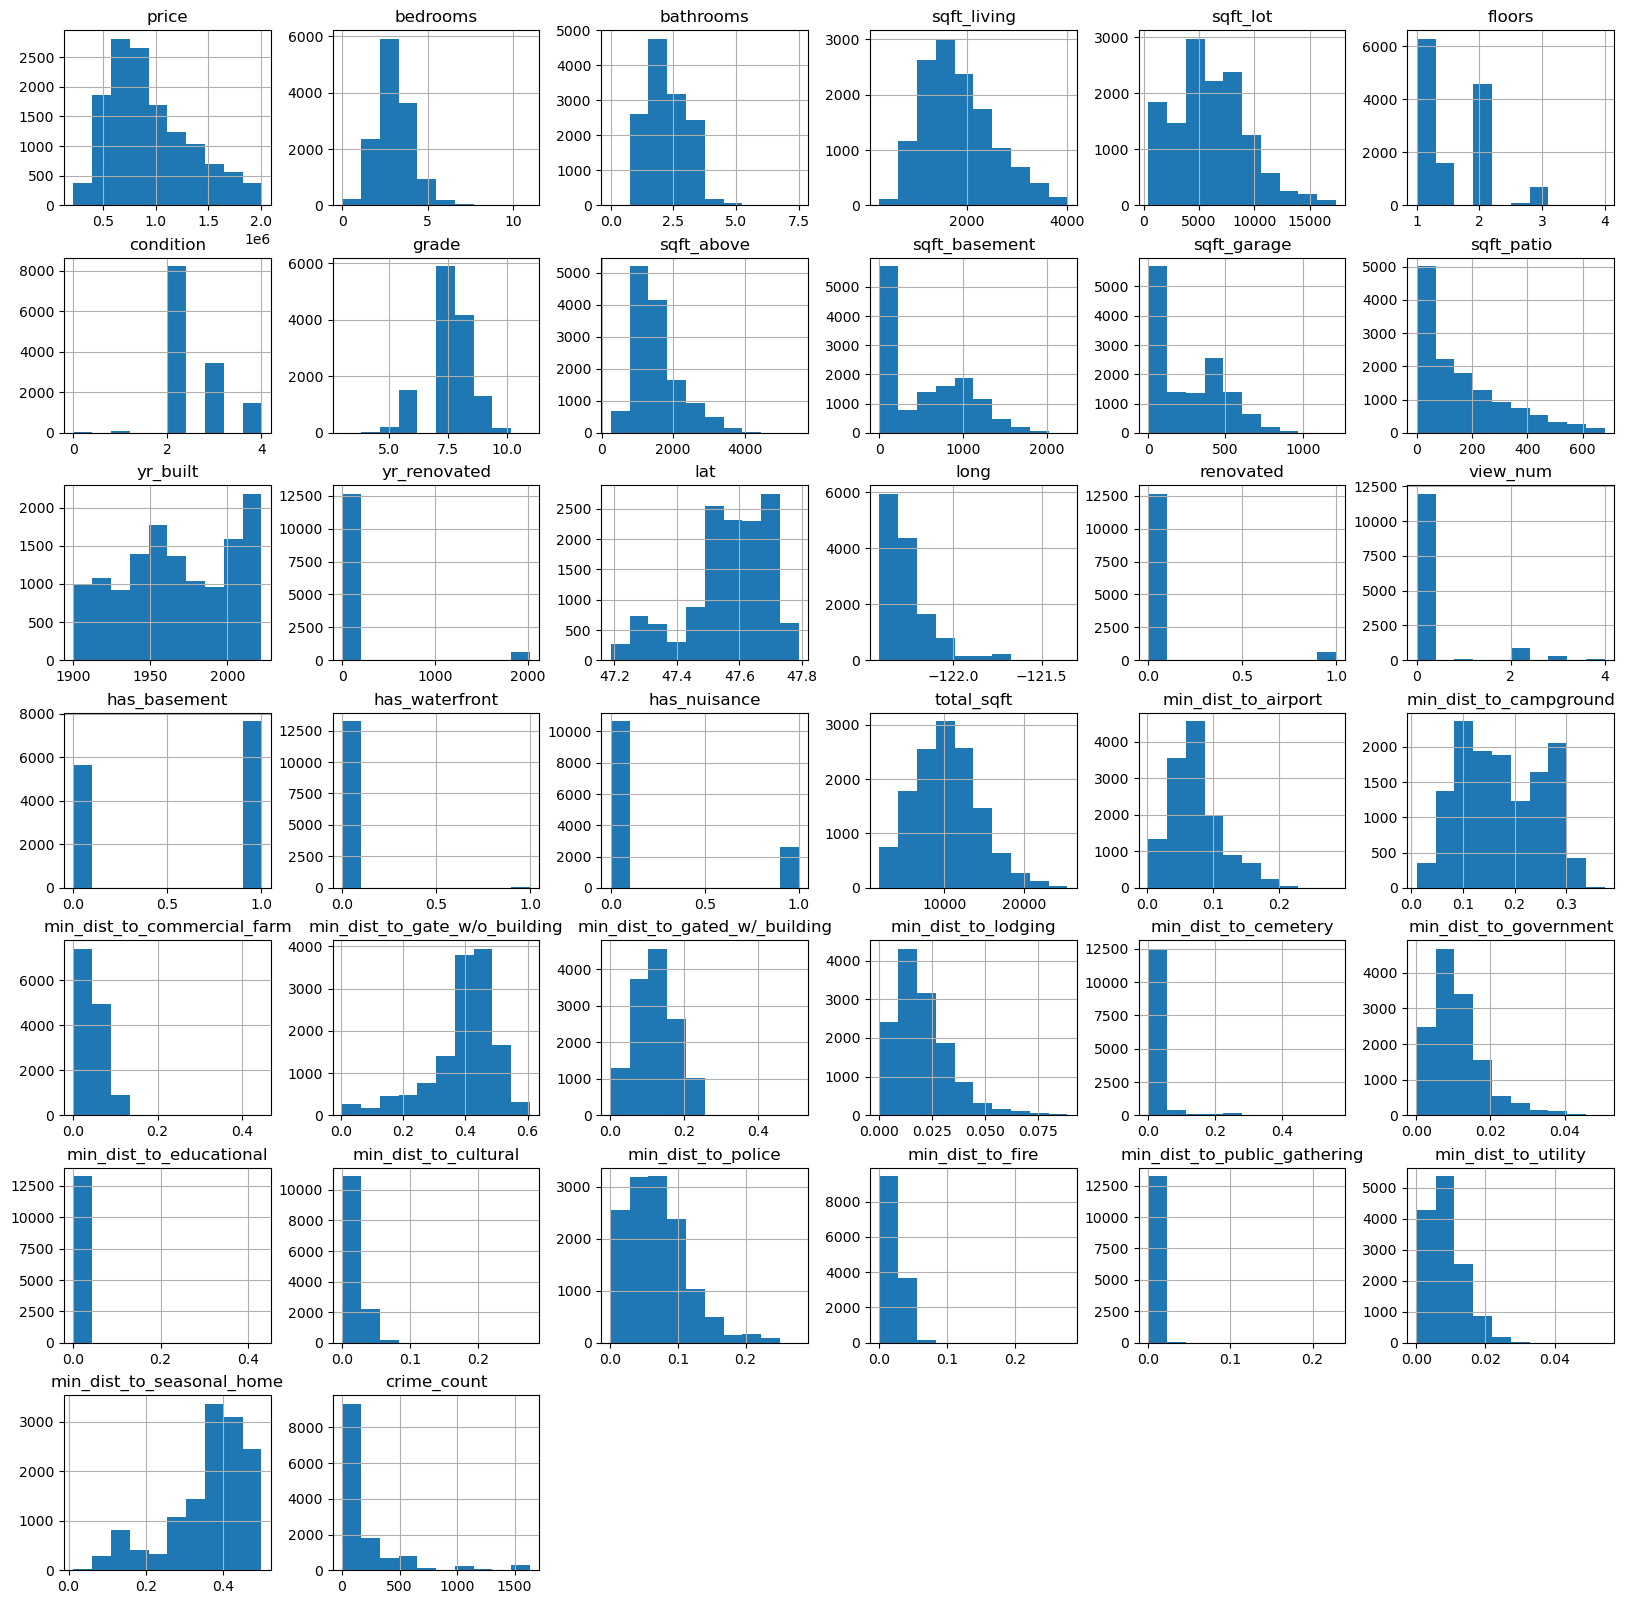

In [72]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca()
merged_df.hist(ax = ax);

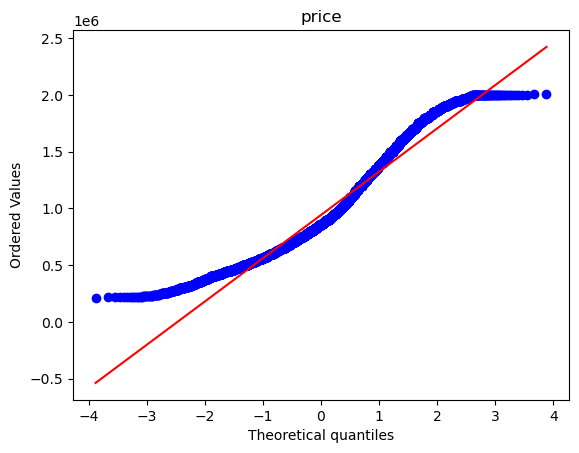

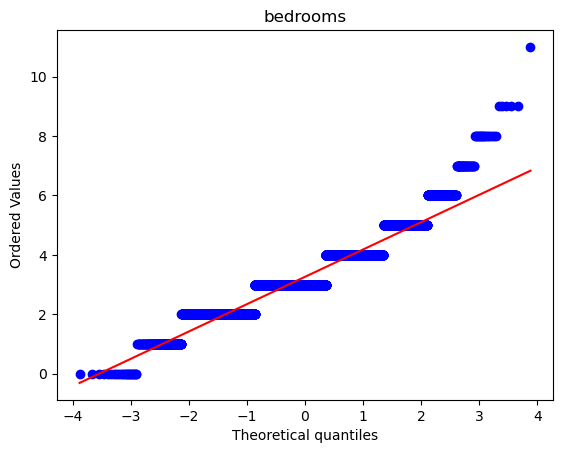

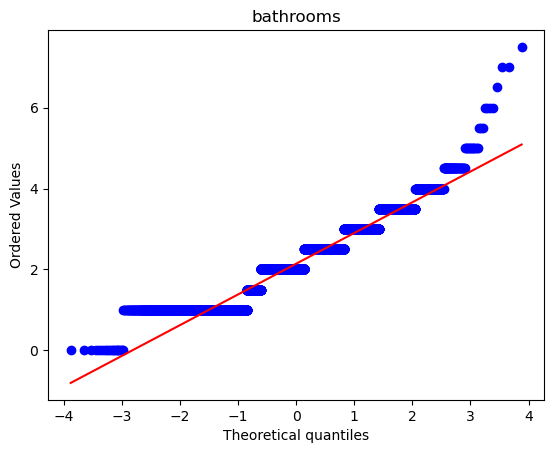

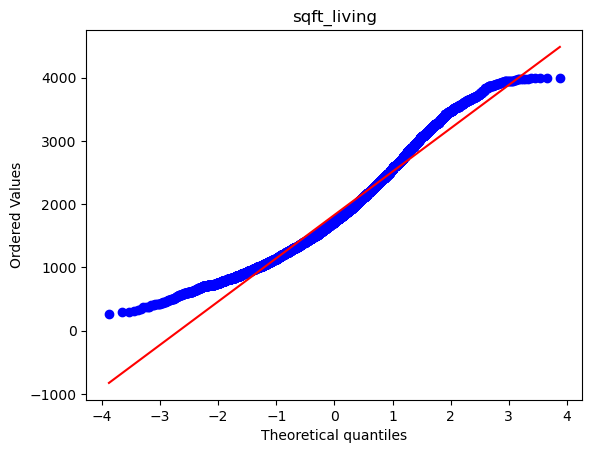

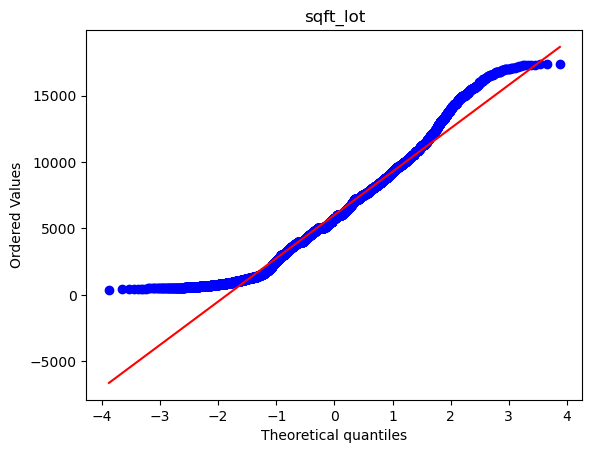

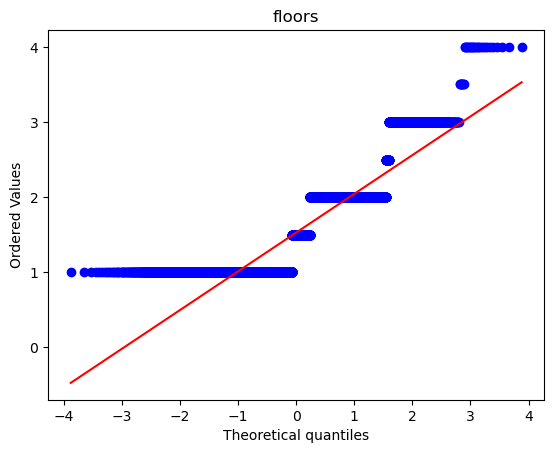

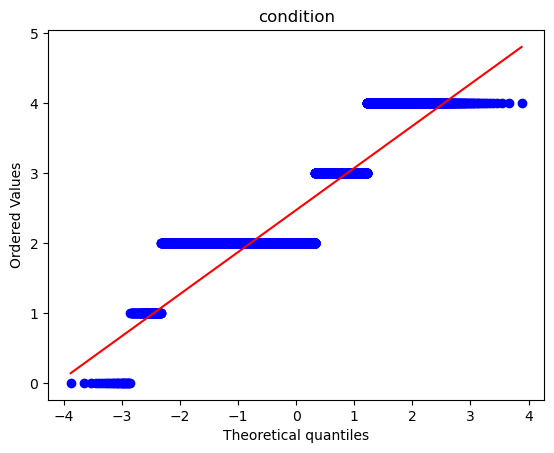

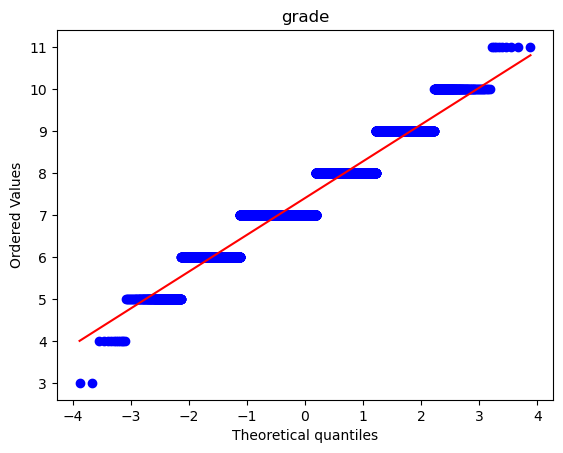

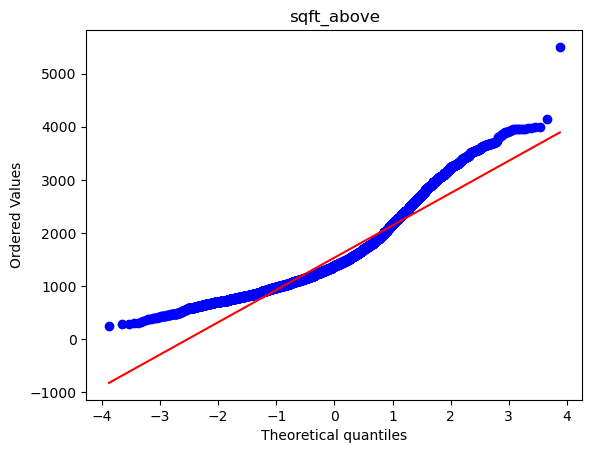

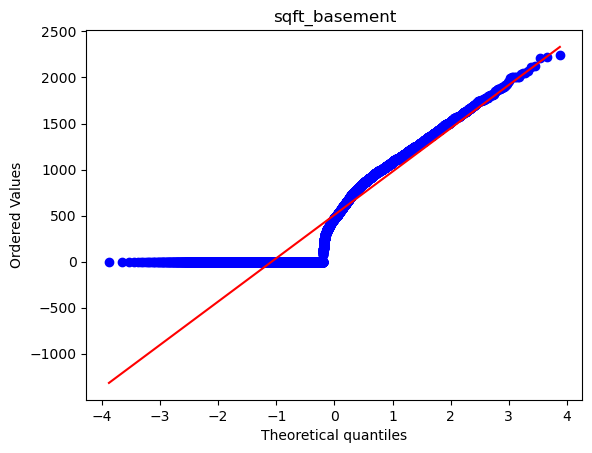

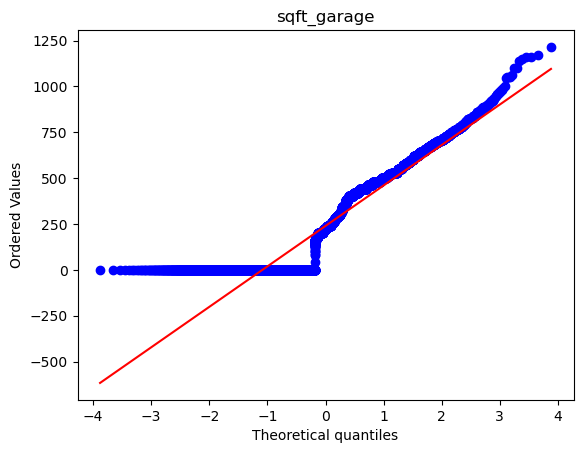

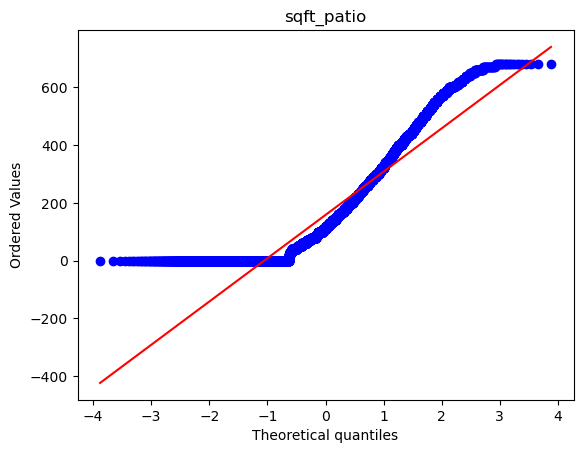

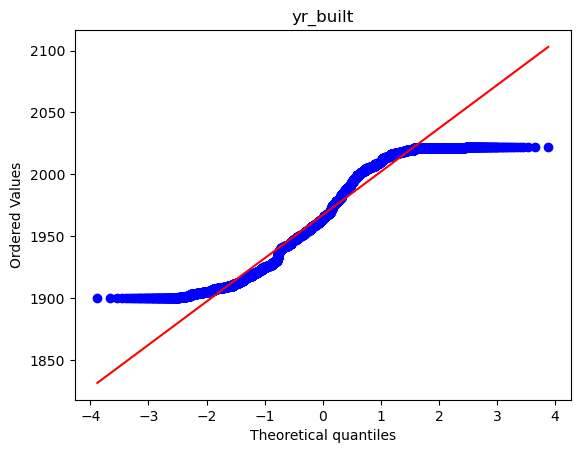

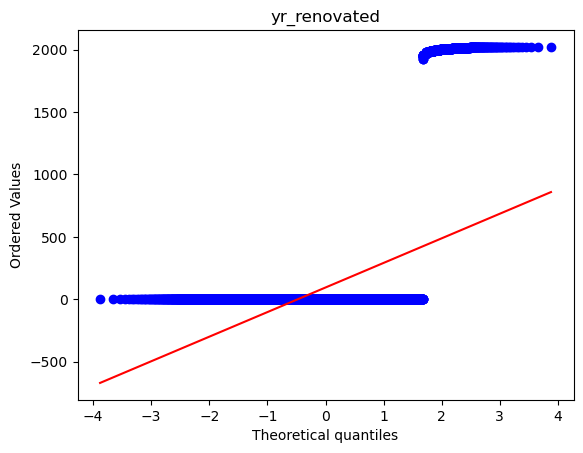

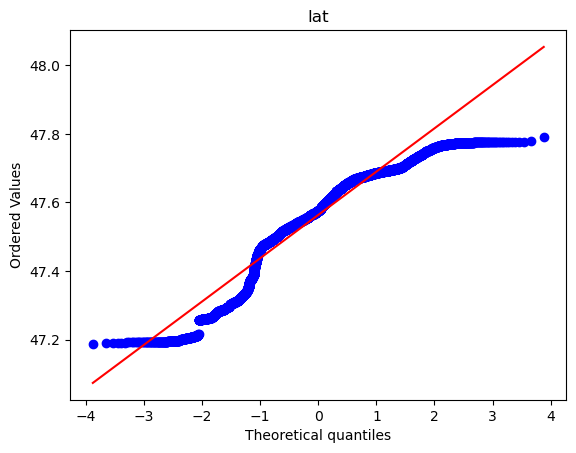

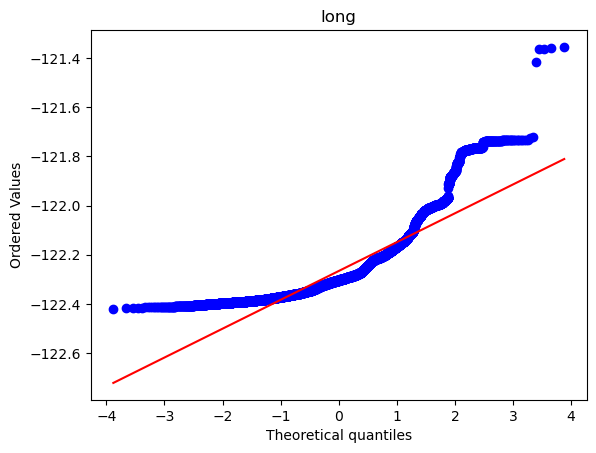

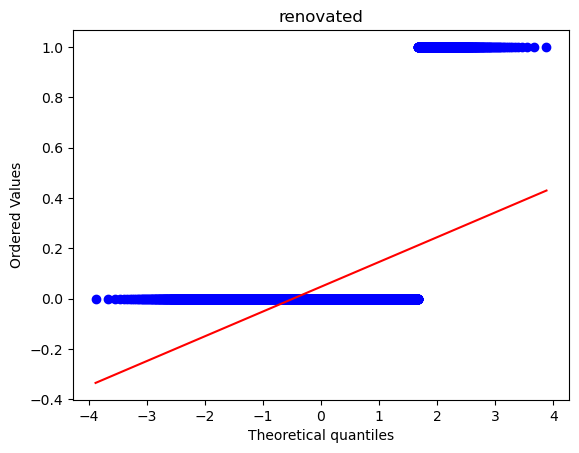

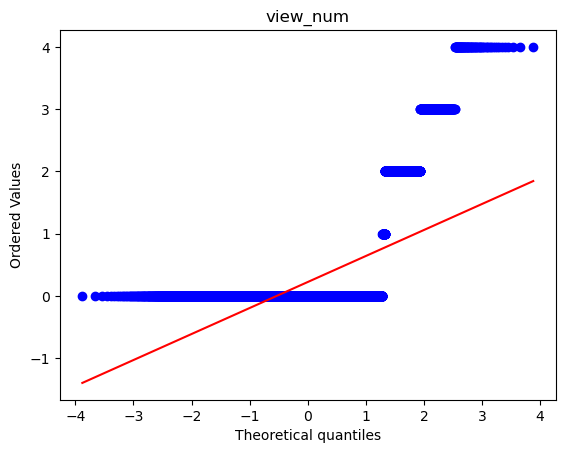

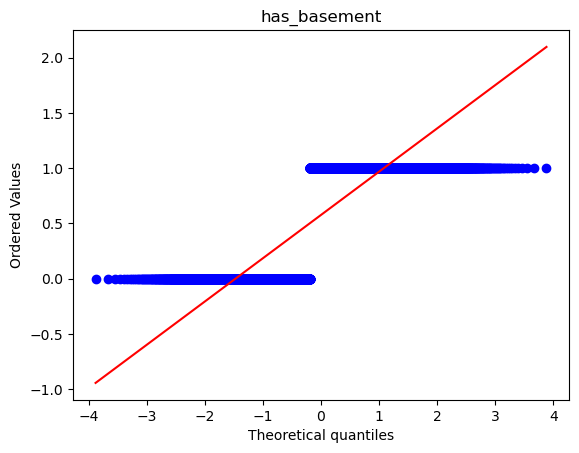

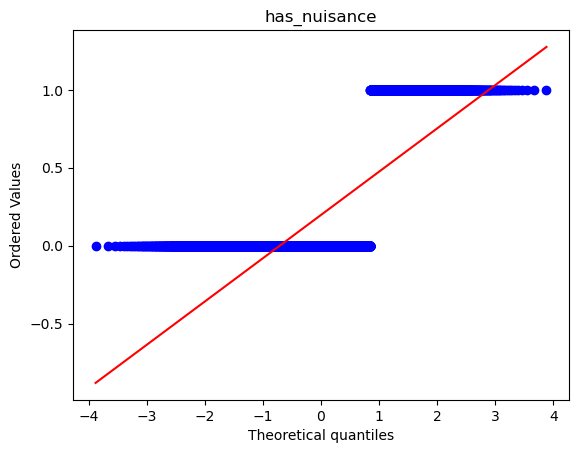

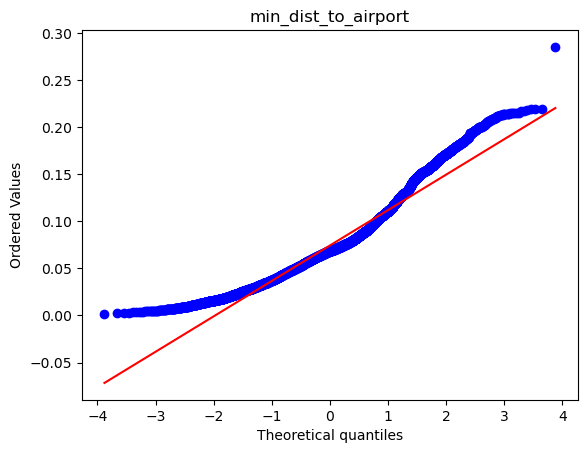

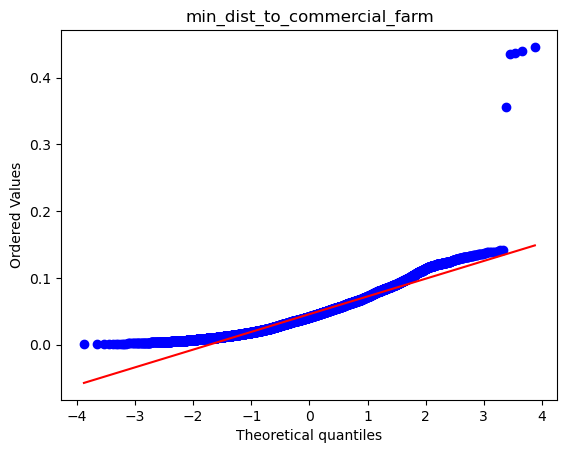

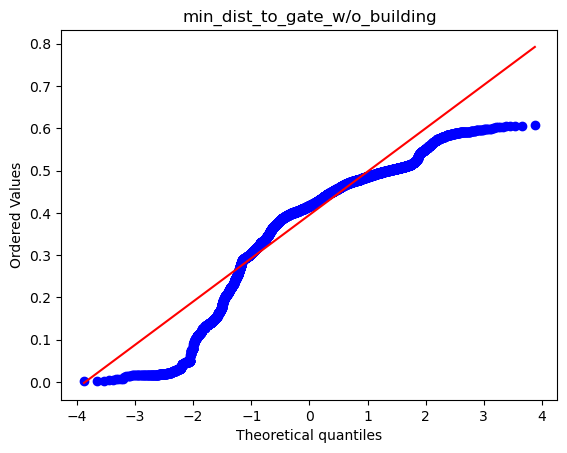

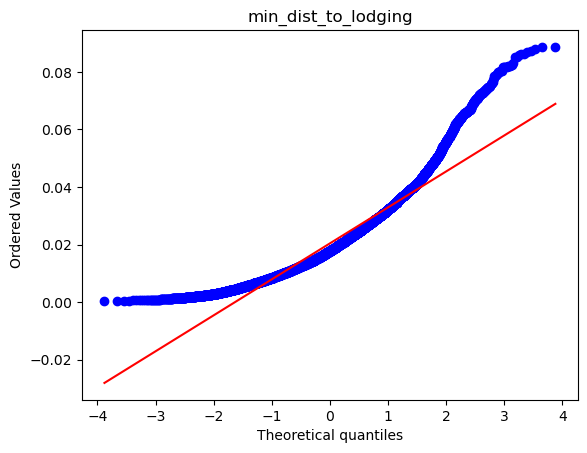

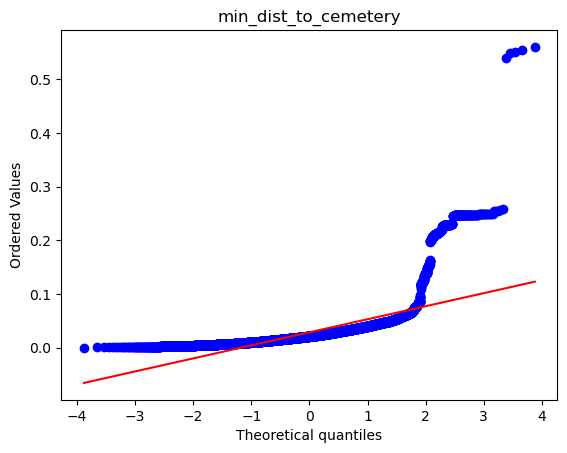

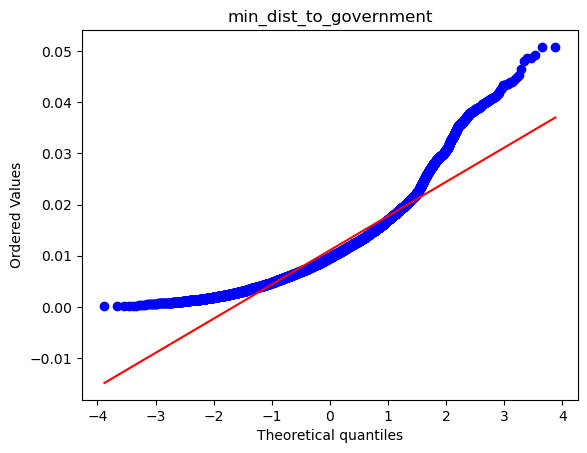

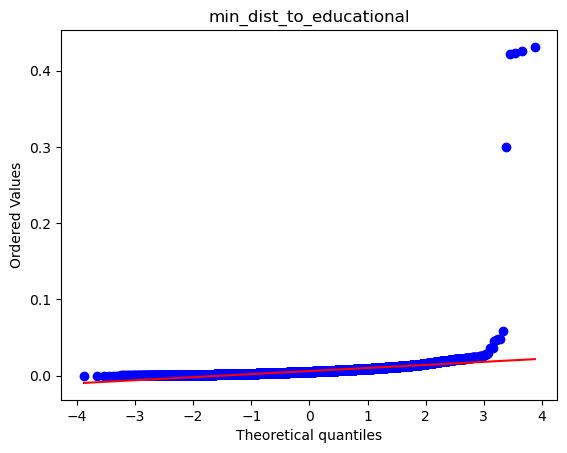

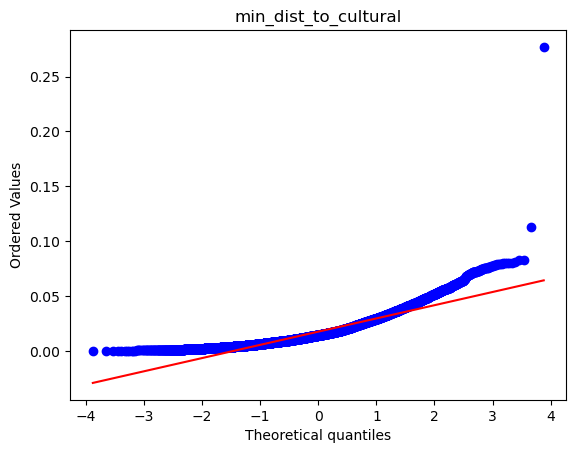

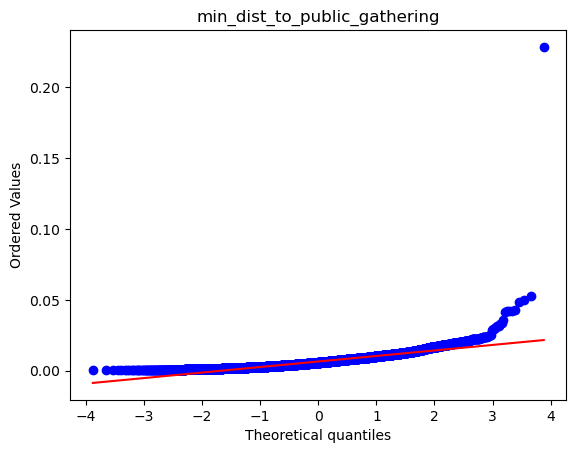

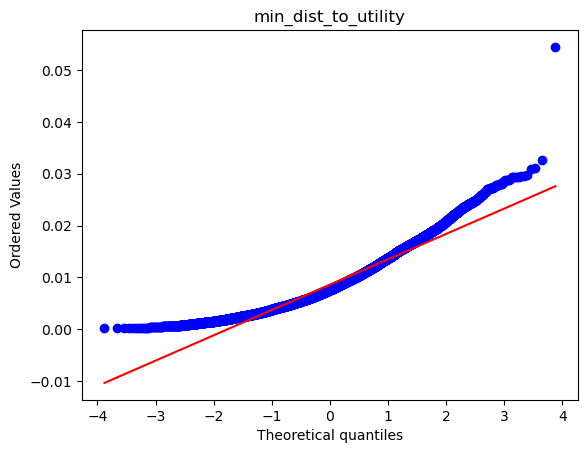

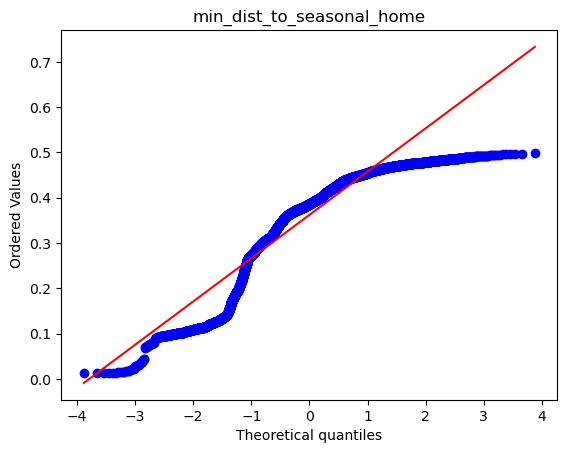

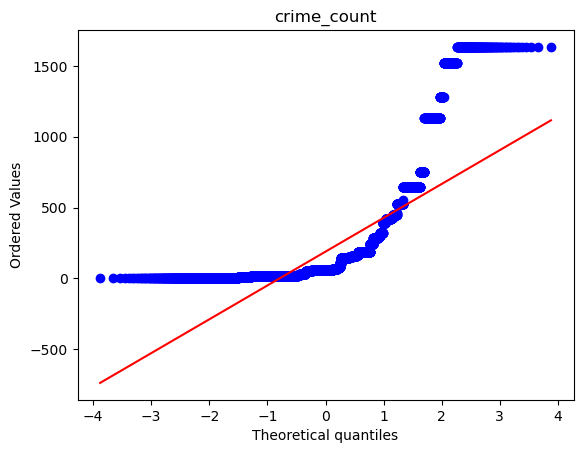

In [73]:
numerical_columns = merged_df.select_dtypes(include=['int64', 'float64', 'int32']).columns
# create a normal probability plot for each numerical column
for column in numerical_columns:
    fig, ax = plt.subplots()
    stats.probplot(merged_df[column], plot=ax)
    ax.set_title(column)
    plt.show()

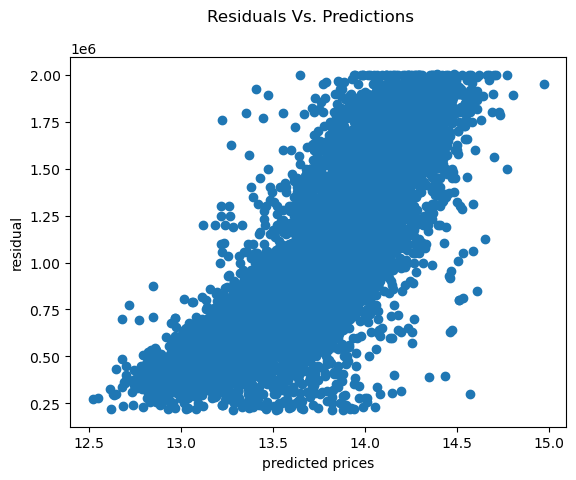

In [74]:
model_preds = model_sk.predict(X)
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

In [75]:
dw = sm.stats.stattools.durbin_watson

In [76]:
dw(resids)

0.16888374490637903

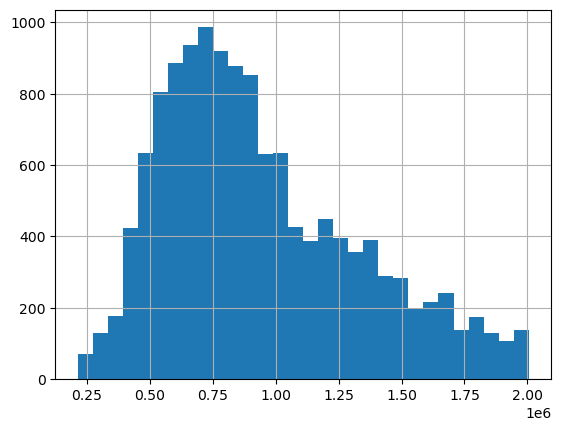

In [77]:
resids.hist(bins=30);

In [78]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13284 entries, 0 to 13283
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          13284 non-null  float64
 1   bedrooms                       13284 non-null  int64  
 2   bathrooms                      13284 non-null  float64
 3   sqft_living                    13284 non-null  int64  
 4   sqft_lot                       13284 non-null  int64  
 5   floors                         13284 non-null  float64
 6   condition                      13284 non-null  int64  
 7   grade                          13284 non-null  int32  
 8   sqft_above                     13284 non-null  int64  
 9   sqft_basement                  13284 non-null  int64  
 10  sqft_garage                    13284 non-null  int64  
 11  sqft_patio                     13284 non-null  int64  
 12  yr_built                       13284 non-null 

In [79]:
merged_df = merged_df.assign(house_location=merged_df['lat'] + merged_df['long'])
merged_df = merged_df.drop(columns = ['long'])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13284 entries, 0 to 13283
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          13284 non-null  float64
 1   bedrooms                       13284 non-null  int64  
 2   bathrooms                      13284 non-null  float64
 3   sqft_living                    13284 non-null  int64  
 4   sqft_lot                       13284 non-null  int64  
 5   floors                         13284 non-null  float64
 6   condition                      13284 non-null  int64  
 7   grade                          13284 non-null  int32  
 8   sqft_above                     13284 non-null  int64  
 9   sqft_basement                  13284 non-null  int64  
 10  sqft_garage                    13284 non-null  int64  
 11  sqft_patio                     13284 non-null  int64  
 12  yr_built                       13284 non-null 

In [94]:
X = merged_df.drop("price", axis=1)
y = merged_df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                             columns=X_test.columns,
                             index=X_test.index)
# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train_scaled, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train_scaled)
test_preds = model_sk.predict(X_test_scaled)
# Calculate the R^2 score on the training data
r2_score(y_train, train_preds)

0.687047000541036

In [95]:
print('Training R^2 score:', r2_score(y_train, train_preds))
print('Test R^2 score:', r2_score(y_test, test_preds))

Training R^2 score: 0.687047000541036
Test R^2 score: 0.7101878998512614


In [96]:
#merged_df['number_of_rooms'] = merged_df['bedrooms'] + merged_df['bathrooms']
#merged_df['sqft_per_room'] = merged_df['sqft_living'] / merged_df['number_of_rooms']

In [97]:
print("Mean absolute error on training data: ", mean_absolute_error(y_train, train_preds))

# Root mean squared error on training data
print("Root mean squared error on training data: ", np.sqrt(mean_squared_error(y_train, train_preds)))

Mean absolute error on training data:  159116.4767071292
Root mean squared error on training data:  219254.72342259844


In [98]:
print("Mean absolute error on test data: ", mean_absolute_error(y_test, test_preds))

# Root mean squared error on test data
print("Root mean squared error on test data: ", np.sqrt(mean_squared_error(y_test, test_preds)))

Mean absolute error on test data:  154950.32558397143
Root mean squared error on test data:  210087.22825729326


In [85]:
merged_df['lot_size_ratio'] = merged_df['sqft_lot'] / merged_df['sqft_living']
merged_df['lot_ratio'] = merged_df['sqft_living'] / merged_df['sqft_lot']

In [100]:
X = merged_df.drop("price", axis=1)
y = merged_df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                             columns=X_test.columns,
                             index=X_test.index)
# Initialize the linear regression model
model_sk = LinearRegression()

# Fit the model on the training data
model_sk.fit(X_train_scaled, y_train)

# Predict on the training data
train_preds = model_sk.predict(X_train_scaled)
test_preds = model_sk.predict(X_test_scaled)
# Calculate the R^2 score on the training data
r2_score(y_train, train_preds)
X_train

bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  grade  \
8086          4        2.5         2050      8921     2.0          2      8   
6174          4        1.0         1650     11430     1.0          2      7   
9152          3        2.5         1480      4000     2.0          3      8   
5438          3        2.5         1470      1571     2.0          2      8   
356           5        3.0         2290      5001     1.0          3      7   
...         ...        ...          ...       ...     ...        ...    ...   
11964         4        1.5         1930      5600     1.5          3      7   
5191          3        2.5         1680      7810     1.0          2      8   
5390          4        2.5         2300      5000     2.0          2      9   
860           4        3.0         2600     11700     1.0          4      7   
7270          1        1.0          690      2498     1.0          2      6   

       sqft_above  sqft_basement  sqft_garage  ...  min_dist_to_cultural  \
8086         2050              0          640  ...              0.004974   
6174         1650              0          360  ...              0.011716   
9152         1480              0          440  ...              0.046719   
5438         1150            510          190  ...              0.013122   
356          1350           1340          510  ...              0.008011   
...           ...            ...          ...  ...                   ...   
11964        1770           1080            0  ...              0.002999   
5191         1680              0          440  ...              0.028877   
5390         2300           1150          670  ...              0.019508   
860          1300           1300          460  ...              0.018201   
7270          690              0            0  ...              0.002780   

       min_dist_to_police  min_dist_to_fire  min_dist_to_public_gathering  \
8086             0.092877          0.023853                      0.004094   
6174             0.121080          0.014090                      0.012924   
9152             0.169626          0.027206                      0.001232   
5438             0.063730          0.012274                      0.008393   
356              0.033037          0.035155                      0.006906   
...                   ...               ...                           ...   
11964            0.011499          0.006058                      0.001362   
5191             0.036479          0.040852                      0.005043   
5390             0.063679          0.022050                      0.014767   
860              0.134542          0.011401                      0.011801   
7270             0.037980          0.015613                      0.000529   

      min_dist_to_utility  min_dist_to_seasonal_home  crime_count  \
8086             0.005133                   0.395836          392   
6174             0.009817                   0.279423           67   
9152             0.001530                   0.113401           50   
5438             0.005434                   0.468783           18   
356              0.005036                   0.367459          145   
...                   ...                        ...          ...   
11964            0.005257                   0.099557          417   
5191             0.006738                   0.240988            8   
5390             0.016153                   0.485276           18   
860              0.012810                   0.177454          319   
7270             0.003927                   0.451530          643   

       house_location  lot_size_ratio  lot_ratio  
8086       -74.963570        4.351707   0.229795  
6174       -74.656000        6.927273   0.144357  
9152       -74.435110        2.702703   0.370000  
5438       -74.815045        1.068707   0.935710  
356        -74.738665        2.183843   0.457908  
...               ...             ...        ...  
11964      -74.782520        2.901

In [91]:
print('Training R^2 score:', r2_score(y_train, train_preds))
print('Test R^2 score:', r2_score(y_test, test_preds))

Training R^2 score: 0.687047000541036
Test R^2 score: 0.7101878998512614


In [92]:
print("Mean absolute error on training data: ", mean_absolute_error(y_train, train_preds))

# Root mean squared error on training data
print("Root mean squared error on training data: ", np.sqrt(mean_squared_error(y_train, train_preds)))

Mean absolute error on training data:  159116.4767071292
Root mean squared error on training data:  219254.72342259844


In [93]:
print("Mean absolute error on test data: ", mean_absolute_error(y_test, test_preds))

# Root mean squared error on test data
print("Root mean squared error on test data: ", np.sqrt(mean_squared_error(y_test, test_preds)))

Mean absolute error on test data:  154950.32558397143
Root mean squared error on test data:  210087.22825729326


In [104]:
merged_df.corr()['price'].sort_values(ascending=False)

price                            1.000000
sqft_living                      0.565888
grade                            0.502173
house_location                   0.464284
sqft_above                       0.448868
lat                              0.430010
bathrooms                        0.408885
bedrooms                         0.324878
sqft_basement                    0.264604
total_sqft                       0.260859
sqft_patio                       0.211803
view_num                         0.194729
min_dist_to_police               0.191894
sqft_garage                      0.184565
has_basement                     0.177959
min_dist_to_campground           0.161493
floors                           0.156363
min_dist_to_airport              0.151566
min_dist_to_cultural             0.139746
min_dist_to_cemetery             0.136414
min_dist_to_public_gathering     0.117794
min_dist_to_utility              0.083250
min_dist_to_government           0.082135
condition                        0

In [105]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13284 entries, 0 to 13283
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          13284 non-null  float64
 1   bedrooms                       13284 non-null  int64  
 2   bathrooms                      13284 non-null  float64
 3   sqft_living                    13284 non-null  int64  
 4   sqft_lot                       13284 non-null  int64  
 5   floors                         13284 non-null  float64
 6   condition                      13284 non-null  int64  
 7   grade                          13284 non-null  int32  
 8   sqft_above                     13284 non-null  int64  
 9   sqft_basement                  13284 non-null  int64  
 10  sqft_garage                    13284 non-null  int64  
 11  sqft_patio                     13284 non-null  int64  
 12  yr_built                       13284 non-null 

In [ ]:
X = merged_df.drop("price", axis=1)
y = merged_df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train